## Visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Tuple, Optional
from dataclasses import dataclass
from enum import Enum
from matplotlib.animation import FuncAnimation


@dataclass
class MatplotlibVizConfig:
    # config for scientific visualization with matplotlib and save as svg
    figsize: Tuple[int, int] = (10, 10)
    dpi: int = 100
    background_color: str = "white"
    font_size: int = 20
    font_family: str = "Arial"
    font_color: str = "black"
    linewidth: int = 2  
    show_grid: bool = True
    use_tex: bool = True
    legend_loc: str = "upper right"
    title: str = ""
    hide_empty_plots: bool = True
    sharey: bool = True

    


class PlotOn(Enum):
    APPEND_RIGHT = "append_right"
    APPEND_DOWN = "append_down"
    RIGHT = "right"


class PlotType(Enum):
    LINE = "line"
    SCATTER = "scatter"
    BAR = "bar"
    HIST = "hist"
    IMAGE = "image"


@dataclass
class Plot:
    X: np.ndarray
    y: Optional[np.ndarray]
    plot_type: PlotType
    plot_order: PlotOn
    plot_row_col: Tuple[int, int] = (-1, -1)
    title: str = ""
    title_size: int = 15
    xlabel: str = ""
    ylabel: str = ""
    label_size: int = 10
    color: str = "blue"
    marker: Optional[str] = None
    linestyle: str = "-"
    linewidth: int = 2
    legend: Optional[str] = "_nolegend_"
    show_legend: bool = True
    legend_size: int = 7
    apply_margin: bool = False
    top_margin: float = 0.9
    bottom_margin: float = 0.1
    left_margin: float = 0.1
    right_margin: float = 0.9
    xmax: Optional[float] = None
    xmin: Optional[float] = None
    ymax: Optional[float] = None
    ymin: Optional[float] = None
    fixed_ymax: bool = False
    allow_animation: bool = True
    



class MatplotlibVisualizer:
    def __init__(self, config: MatplotlibVizConfig):
        self.config = config
        self._plots = []
        self.curr_row = 0
        self.curr_col = 0
        self.num_rows=1
        self.num_cols=1
        self.num_plots = 0
        self.ax_lim = {}
        self.completed_frames = []

    def make_figure(self):
        print(f"Making figure with {self.num_rows} rows and {self.num_cols} columns.")        
        fig, ax = plt.subplots(
            self.num_rows,
            self.num_cols,
            figsize=self.config.figsize,
            dpi=self.config.dpi,
            facecolor=self.config.background_color,
            sharey=self.config.sharey,
            
        )
        fig.suptitle(self.config.title, fontsize=self.config.font_size, fontfamily=self.config.font_family, color=self.config.font_color)
        plt.tight_layout()
        # use latex on text
        if self.config.use_tex:
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
        return fig, np.array(ax).reshape(self.num_rows, self.num_cols)

    def append_plot(
        self,
        plot: Plot,
        left_to_right: bool = True,
    ):
        if self.num_plots == 0:
            self.num_plots += 1
        else:
            if plot.plot_order == PlotOn.APPEND_RIGHT:
                if left_to_right:
                    self.curr_col += 1
            elif plot.plot_order == PlotOn.APPEND_DOWN:
                self.curr_row += 1
                if left_to_right:
                    self.curr_col = 0
            elif plot.plot_order == PlotOn.RIGHT:
                pass
            else:
                raise ValueError("Invalid plot order.")
            self.num_plots += 1
            self.num_rows = max(self.num_rows, self.curr_row + 1)
            self.num_cols = max(self.num_cols, self.curr_col + 1)

        
            
        plot.plot_row_col = (self.curr_row, self.curr_col)

        if plot.X is not None:
            if plot.xmax is None:
                plot.xmax = np.nanmax(plot.X)
            if plot.xmin is None:
                plot.xmin = np.nanmin(plot.X)
            if plot.plot_type == PlotType.IMAGE:
                plot.xmax = plot.X.shape[1]
                plot.xmin = 0
        if plot.y is not None:
            if plot.ymax is None:
                plot.ymax = np.nanmax(plot.y)
            if plot.ymin is None:
                plot.ymin = np.nanmin(plot.y)
        
        self._plots.append(plot)

    def _generate_plot(self, plot: Plot, ax, limit:int=-1):
        curr_row, curr_col = plot.plot_row_col
        key =f'{curr_row}_{curr_col}'
        label = plot.legend
        # print(f"Shape of X: {plot.X.shape}, Limit: {limit}, Label: {label}.")
        if plot.plot_type == PlotType.LINE:
            ax.plot(plot.X[:limit], plot.y[:limit], color=plot.color, marker=plot.marker, linestyle=plot.linestyle, linewidth=plot.linewidth, label=label)
        elif plot.plot_type == PlotType.SCATTER:
            ax.scatter(plot.X[:limit], plot.y[:limit], color=plot.color, marker=plot.marker, linewidth=plot.linewidth, label=label)
        elif plot.plot_type == PlotType.BAR:
            ax.bar(plot.X[:limit], plot.y[:limit], color=plot.color, label=label)
        elif plot.plot_type == PlotType.HIST:
            ax.hist(plot.X[:limit], color=plot.color, label=label)
        elif plot.plot_type == PlotType.IMAGE:
            ax.imshow(plot.X)
        else:
            raise ValueError("Invalid plot type.")

        
        # add left margin
        # print(ax.get_xlim(), ax.get_ylim())
        x_min, x_max = plot.xmin, plot.xmax #ax.get_xlim()
        y_min, y_max = plot.ymin, plot.ymax #ax.get_ylim()
        
        if self.ax_lim.get(key) is None:
            self.ax_lim[key] = []
        else:
            # print(f"Existing limits: {self.ax_lim[key]}, keys: {key}")
            x_min = min(x_min, self.ax_lim[key][0]) if (self.ax_lim[key][0] is not None and x_max is not None) else ax.get_xlim()[0]
            x_max = max(x_max, self.ax_lim[key][1]) if (self.ax_lim[key][1] is not None and x_max is not None) else ax.get_xlim()[1]
            y_min = min(y_min, self.ax_lim[key][2]) if (self.ax_lim[key][2] is not None and y_min is not None) else ax.get_ylim()[0]
            y_max = max(y_max, self.ax_lim[key][3]) if (self.ax_lim[key][3] is not None and y_max is not None) else ax.get_ylim()[1]
        self.ax_lim[key]=[x_min, x_max, y_min, y_max]

        if plot.apply_margin and not plot.fixed_ymax:
            ax.set_xlim(x_min - plot.left_margin, x_max + plot.right_margin)
            if plot.y is not None:                    
                ax.set_ylim(y_min - plot.bottom_margin, y_max + plot.top_margin)
        
        ax.set_title(plot.title, fontsize=plot.title_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.set_xlabel(plot.xlabel, fontsize=plot.label_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.set_ylabel(plot.ylabel, fontsize=plot.label_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.grid(self.config.show_grid)
        
        return ax

    def generate_plots(self, save_path: Optional[Path] = None, format: str = "svg"):        
        # get figure and axes
        fig, ax = self.make_figure()
               
        for plot in self._plots:
            curr_row, curr_col = plot.plot_row_col     
            curr_ax = ax[curr_row, curr_col]
            
            curr_ax = self._generate_plot(plot, curr_ax, limit=plot.X.shape[0])
            if plot.fixed_ymax:
                curr_ax.set_ylim(plot.ymin, plot.ymax)
        
        for plot in self._plots:
            curr_row, curr_col = plot.plot_row_col 
            curr_ax = ax[curr_row, curr_col]
            if plot.show_legend:
                curr_ax.legend(loc=self.config.legend_loc, fontsize=plot.legend_size)
        
        # hide empty plots
        if self.config.hide_empty_plots:
            plot_row_col = [plot.plot_row_col for plot in self._plots]
            for i in range(self.num_rows):
                for j in range(self.num_cols):
                    if (i, j) not in plot_row_col:
                        ax[i, j].axis("off")
        
        if save_path is not None:
            self.save_fig(fig, save_path, format=format)


        return fig, ax

    def _animate(self, curr_frame, ax, num_frames=30):
        curr_frame+=1
        print(f"Animating frame {curr_frame}. Completed frames: {self.completed_frames}. Num frames: {num_frames}.")
        
        for plot in self._plots:
            anim_plot = True
            curr_row, curr_col = plot.plot_row_col
            curr_ax = ax[curr_row, curr_col]
            if curr_frame>1 or curr_frame in self.completed_frames:
                plot.legend = '_nolegend_'
            
            if plot.allow_animation:
                limit = int((curr_frame+1) * len(plot.X) / num_frames)
            else:
                if curr_frame==1:            
                    limit = len(plot.X)
                else:
                    anim_plot = False
            if anim_plot:
                curr_ax = self._generate_plot(plot, curr_ax, limit=limit)
        self.completed_frames.append(curr_frame)
            
        for plot in self._plots:
            curr_row, curr_col = plot.plot_row_col 
            curr_ax = ax[curr_row, curr_col]
            if plot.show_legend:
                curr_ax.legend(loc=self.config.legend_loc, fontsize=plot.legend_size)
            
        # hide empty plots
        if self.config.hide_empty_plots:
            plot_row_col = [plot.plot_row_col for plot in self._plots]
            for i in range(self.num_rows):
                for j in range(self.num_cols):
                    if (i, j) not in plot_row_col:
                        ax[i, j].axis("off")
        
        return ax
    
    def animate_plots(self, interval: int = 10, frames: int = 10, save_path: Optional[Path] = None):
        fig, ax = self.make_figure()
        anim = FuncAnimation(fig, self._animate, frames=frames, fargs=(ax, frames,), interval=interval)
        if save_path is not None:
            self.save_animation(anim, save_path)
        return anim
    
    def save_animation(self, anim, path: Path):
        anim.save(path)

    def save_fig(self, fig:plt.Figure, path: Path, format: str = "svg"):
        fig.savefig(path, format=format, dpi=self.config.dpi, bbox_inches='tight')

    def show_fig(self):
        plt.show()

    def close_fig(self, fig):
        plt.close(fig)
    
    def clear_plots(self):
        self._plots = []
        self.num_plots = 0
        self.curr_row = 0
        self.curr_col = 0
        self.num_rows=1
        self.num_cols=1
        plt.clf()
    

Making figure with 3 rows and 2 columns.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


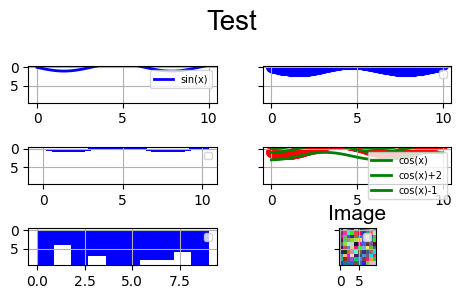

In [2]:
viz_config = MatplotlibVizConfig(figsize=(5,3),title="Test",
                                 use_tex=False,)
viz = MatplotlibVisualizer(config=viz_config)

X = np.linspace(0, 10, 110)
y = np.sin(X)
z = np.cos(X)
w = y+z

# show legend in latex format

plot1 = Plot(X=X, y=y, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="sin(x)")
plot2 = Plot(X=X, y=y, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT)
plot3 = Plot(X=X, y=y, plot_type=PlotType.BAR, plot_order=PlotOn.APPEND_DOWN)
plot4 = Plot(X=X, y=z, plot_type=PlotType.LINE, plot_order=PlotOn.APPEND_RIGHT, legend="cos(x)", color="green", allow_animation=False)
plot41 = Plot(X=X, y=z+2, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="cos(x)+2", color="green", allow_animation=False)
plot42 = Plot(X=X, y=z-1, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="cos(x)-1", color="green", allow_animation=False)
plot5 = Plot(X=X, y=w, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, legend="sin(x)+cos(x)", color="red")
plot5 = Plot(X=X, y=w, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, color="red", allow_animation=False)

plot6 = Plot(X=np.random.randint(0, 10, 100), y=None, plot_type=PlotType.HIST, plot_order=PlotOn.APPEND_DOWN)
plot7 = Plot(X=np.random.randint(0, 255,(10,10, 3)), y=None, plot_type=PlotType.IMAGE, plot_order=PlotOn.APPEND_RIGHT, title="Image")


viz.append_plot(plot1)
viz.append_plot(plot2)
viz.append_plot(plot3)
viz.append_plot(plot4)
viz.append_plot(plot41)
viz.append_plot(plot42)
viz.append_plot(plot5)
viz.append_plot(plot6)
viz.append_plot(plot7)


fig, ax = viz.generate_plots()
viz.save_fig(fig, Path("expt_res/test.png"), 'png')
viz.show_fig()
# viz.close_fig(fig)
# print(ax)

MovieWriter imagemagick unavailable; using Pillow instead.


Making figure with 3 rows and 2 columns.
Animating frame 1. Completed frames: []. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Animating frame 1. Completed frames: [1]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 2. Completed frames: [1, 1]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 3. Completed frames: [1, 1, 2]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 4. Completed frames: [1, 1, 2, 3]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 5. Completed frames: [1, 1, 2, 3, 4]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 6. Completed frames: [1, 1, 2, 3, 4, 5]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 7. Completed frames: [1, 1, 2, 3, 4, 5, 6]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 8. Completed frames: [1, 1, 2, 3, 4, 5, 6, 7]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 9. Completed frames: [1, 1, 2, 3, 4, 5, 6, 7, 8]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 10. Completed frames: [1, 1, 2, 3, 4, 5, 6, 7, 8, 9]. Num frames: 10.


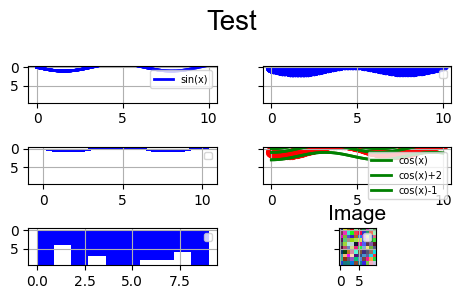

In [3]:
viz.animate_plots(interval=90,frames=10).save('expt_res/test.gif', writer='imagemagick', fps=30)

## Loss

In [4]:
from enum import Enum
import numpy as np


class LossType(Enum):
    MSE = "mean_squared_error"
    MAE = "mean_absolute_error"
    HINGE = "hinge"
    RMSE = "root_mean_squared_error"


class Loss:
    def __init__(self, loss_type: LossType):
        self.loss_type = loss_type
        self.name = loss_type.value

    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        if self.loss_type == LossType.MSE:
            return self.mean_squared_error(y_true, y_pred)
        elif self.loss_type == LossType.MAE:
            return self.mean_absolute_error(y_true, y_pred)
        elif self.loss_type == LossType.HINGE:
            return self.hinge(y_true, y_pred)
        elif self.loss_type == LossType.RMSE:
            return self.mean_squared_error(y_true, y_pred)**0.5
        else:
            raise ValueError(f"Loss type {self.loss_type} not supported")

    def mean_squared_error(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return ((y_true - y_pred) ** 2).mean()

    def mean_absolute_error(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return (y_true - y_pred).abs().mean()

    def hinge(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return (1 - y_true * y_pred).clip(min=0).mean()


## Data Generator

In [5]:
from typing import Union
import torch
from torch.utils.data import Dataset

@dataclass
class DataGeneratorConfig:
    num_rows: int
    num_cols: int
    min_val: int = 0
    max_val: int = 100
    seed: int = 100
    normalize: bool = True
    noise: Union[float, np.ndarray] = None
    weights: Optional[np.ndarray] = None
    biases: Optional[np.ndarray] = None
    noise_norm_by: Optional[float] = 1.0



class DataGenerator:
    def __init__(self, config: DataGeneratorConfig):
        self.config = config

        np.random.seed(self.config.seed)
        self.X = np.random.uniform(self.config.min_val, self.config.max_val+1, (self.config.num_rows, self.config.num_cols))
        self.noise = self.config.noise if self.config.noise is not None else np.random.standard_normal(self.config.num_rows)/self.config.noise_norm_by
        self.normalize = self.config.normalize
        if self.config.normalize:
            self.X = self.X/np.max(self.X)
            # self.noise = self.noise/self.config.max_val
        self.weights = self.config.weights
        self.biases = self.config.biases
        # self.noise = self.config.noise if self.config.noise is not None else np.random.randn(self.config.num_rows)

    def make_data(self):
        if self.weights is None:
            self.weights = np.random.standard_normal(self.X.shape[1])
        if self.biases is None:
            self.biases = np.random.standard_normal(1)        

        self.y = np.dot(self.X, self.weights) + self.biases + self.noise
        self.X, self.y = torch.tensor(self.X, dtype=torch.float32), torch.tensor(self.y, dtype=torch.float32)
        return self.X, self.y

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            raise ValueError("No y values found. Please generate data first.")
        return self.X[idx], self.y[idx]

## make sure the data is generated correctly
data_gen1 = DataGenerator(DataGeneratorConfig(num_rows=1000, num_cols=20))
data_gen1.make_data()

data_gen2 = DataGenerator(DataGeneratorConfig(num_rows=1000, num_cols=20))
data_gen2.make_data()
(data_gen2.weights == data_gen1.weights).all(), (data_gen2.biases == data_gen1.biases).all(),(data_gen1.noise == data_gen2.noise).all()

(True, True, True)

## Experiment

In [6]:
import torch.nn as nn
from typing import List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
from dataclasses import asdict, field
from typing import Union, Optional

from gradls.vis.colors import visible_colors

class Optimizer(Enum):
    SGD = "sgd"
    MOMENTUM = "momentum"
    NESTEROV = "nesterov"
    ADAM = "adam"
    RMSPROP = "rmsprop"
    ADAGRAD = "adagrad"
    ADADELTA = "adadelta"
    ADAMAX = "adamax"




@dataclass
class ExperimentConfig:
    name: str
    viz_config: MatplotlibVizConfig
    num_epochs:int
    batch_size:int
    loss:LossType
    model:Optional[nn.Module]=None
    optimizer:Optimizer=Optimizer.SGD
    learning_rate:float=0.01
    momentum:float=0.0
    train_valid_split:float=0.1
    seed:Optional[int]=100
    metrics:List[LossType]=field(default_factory=lambda:[LossType.MAE])
    log_every:int=1
    log_dir:Path=None
    log_anim:bool=True
    log_plots:bool=True
    plot_format:str='png'
    anim_interval:int=100 
    anim_frames:int=10
    anim_fps:int=30
    log_real_params:bool=True
    log_real_data:bool=True
    verbose:bool=False
    device:str='cpu'

class Runner:
    def __init__(self, name:str, model:nn.Module, batch_size:int, optimizer:str, loss:Loss, 
                 metrics:Optional[List[Loss]]=[], log_every:int=1, log_params:bool=False,
                 is_test:bool=False, data:Dataset=None, l1_penalty:float=0.0, l2_penalty:float=0.0, device:str='cuda'):
        self.name = name
        self.batch_size = batch_size
        self.metrics = metrics
        self.loss = loss
        self.optimizer = optimizer
        self.model = model
        self.is_test = is_test
        self.data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
        self.logs = {metric.name:[] for metric in self.metrics}
        self.logs[f"{name}_loss({loss.name})"] = []
        self.curr_epoch = 0
        self.log_every = log_every
        self.log_params = log_params
        self.logs['epochs']=[]
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        self.device = device
        self.model.to(self.device)
        
        if log_params:
            self.logs['weights']=[]
            self.logs['biases']=[]
            self.logs['weight_gradients']=[]
            self.logs['bias_gradients']=[]
            self.logs['learning_rate']=[]
        
    
    def step(self):
        batch_losses = []
        batch_metrics = {metric.name:[] for metric in self.metrics}
        # print(self.metrics)
        
        # all_preds = []
        if self.is_test:
            self.model.eval()
        else:
            self.model.train()

        for i, (X, y) in enumerate(self.data_loader):
            # print(X.shape, y.shape)
            if not self.is_test:
                self.optimizer.zero_grad()
            X, y = X.to(self.device), y.to(self.device)
            y_pred = self.model(X)
            
            # if self.log_output:
            #     all_preds.extend(y_pred.detach().numpy().tolist())



            loss = self.loss(y, y_pred.squeeze())
            batch_losses.append(loss.item())

            params = torch.cat([p.view(-1) for p in self.model.parameters()])
            # print(loss)
            
            if self.l1_penalty > 0:
                loss += self.l1_penalty * torch.abs(params).sum()
            if self.l2_penalty > 0:
                loss += self.l2_penalty * (params**2).sum()

            if not self.is_test:
                # self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            for metric in self.metrics:
                batch_metrics[metric.name].append(metric(y, y_pred).detach().numpy())

        if self.curr_epoch % self.log_every == 0:    
            epoch_loss = np.mean(batch_losses)
            epoch_metrics = {metric.name:np.mean(batch_metrics[metric.name]) for metric in self.metrics}
            self.logs[f"{self.name}_loss({self.loss.name})"].append(epoch_loss)
            for metric in self.metrics:
                self.logs[metric.name].append(epoch_metrics[metric.name])
            
            self.logs['epochs'].append(self.curr_epoch)

            if self.log_params:
                self.logs['weights'].append(self.model.weight.data.numpy().copy())
                self.logs['biases'].append(self.model.bias.data.numpy().copy())
                if not self.is_test:
                    self.logs['weight_gradients'].append(self.model.weight.grad.data.numpy().copy())
                    self.logs['bias_gradients'].append(self.model.bias.grad.data.numpy().copy())
                    self.logs['learning_rate'].append(self.optimizer.param_groups[0]['lr'])
        self.curr_epoch += 1

        # if self.log_output:
        #     self.predictions.append(all_preds)

        return epoch_loss, epoch_metrics


class Experiment:
    def __init__(self, config: ExperimentConfig):
        if config.seed is None:
            config.seed = np.random.randint(0, 100) 
        torch.manual_seed(config.seed)
        self.config = config
        self.viz_config = config.viz_config
        self.viz = MatplotlibVisualizer(config=self.viz_config)
        self.losses = {}
        self.metrics = {metric.value:[] for metric in self.config.metrics}
        self.optimizer = None
        self.real_weights = None
        self.real_biases = None
        self.logs=None
        self.loss_fxn = Loss(self.config.loss)       
        
    
    def load_data(self, data:DataGenerator):
        self.data_config = data.config
        self.data = data
        X, y = data.make_data()
        self.real_weights = data.weights
        self.real_biases = data.biases
                
        if self.config.model is None:
            self.config.model = nn.Linear(in_features=X.shape[1], out_features=1)

        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=self.config.train_valid_split, random_state=self.config.seed)
        self.train_X, self.val_X, self.train_y, self.val_y = train_X, val_X, train_y, val_y
        self.make_runners()
    
    def make_runners(self):
        train_data = MyDataset(self.train_X, self.train_y)
        val_data = MyDataset(self.val_X, self.val_y)

        if self.config.optimizer == Optimizer.SGD:
            self.optimizer = torch.optim.SGD(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.MOMENTUM:
            self.optimizer = torch.optim.SGD(self.config.model.parameters(), lr=self.config.learning_rate, momentum=self.config.momentum)
        elif self.config.optimizer == Optimizer.NESTEROV:
            self.optimizer = torch.optim.SGD(self.config.model.parameters(), lr=self.config.learning_rate, momentum=self.config.momentum, nesterov=True)
        elif self.config.optimizer == Optimizer.ADAM:
            self.optimizer = torch.optim.Adam(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.RMSPROP:
            self.optimizer = torch.optim.RMSprop(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.ADAGRAD:
            self.optimizer = torch.optim.Adagrad(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.ADADELTA:
            self.optimizer = torch.optim.Adadelta(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.ADAMAX:
            self.optimizer = torch.optim.Adamax(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.ADAMW:
            self.optimizer = torch.optim.AdamW(self.config.model.parameters(), lr=self.config.learning_rate)
        else:
            raise ValueError("Invalid optimizer type.")

        if self.config.batch_size < 1:
            self.config.batch_size = len(train_data)
            train_batch_size = len(train_data)
            test_batch_size = len(val_data)
        else:
            train_batch_size = self.config.batch_size
            test_batch_size = self.config.batch_size
            
        self.train_runner = Runner(name="train",loss=self.loss_fxn, model=self.config.model, batch_size=train_batch_size, optimizer=self.optimizer, 
                                   metrics=[Loss(m) for m in self.config.metrics], data=train_data, log_params=True, device=self.config.device)
        self.val_runner = Runner(name="val", loss=self.loss_fxn,model=self.config.model, batch_size=test_batch_size, optimizer=self.optimizer, 
                                 metrics=[Loss(m) for m in self.config.metrics], is_test=True, data=val_data, device=self.config.device)
    

    def train(self):
        for epoch in range(self.config.num_epochs):
            train_loss, train_metrics = self.train_runner.step()

            with torch.no_grad():
                val_loss, val_metrics = self.val_runner.step()

            self.losses[epoch] = {"train_loss":train_loss, "val_loss":val_loss}
            for metric in self.config.metrics:
                self.metrics[metric.value].append({"train":train_metrics[metric.value], "val":val_metrics[metric.value]})
            
            # train_mse, val_mse, train_bias, val_bias, train_variance, val_variance = self.calculate_bias_variance()

            if epoch % self.config.log_every == 0 and self.config.verbose:
                print(f"Epoch {epoch}: Train Loss: {train_loss}, Val Loss: {val_loss}")
            

        print("Training complete.")
            
    def get_default_plots(self, plot_parameters:bool=True)->List[Plot]:
        plots = []
        colors = visible_colors
        keys = list(colors.values())
        # np.random.shuffle(keys)
        train_loss = np.array([m["train_loss"] for m in self.losses.values()])
        val_loss = np.array([m["val_loss"] for m in self.losses.values()])
        plots.append(Plot(X=np.arange(self.config.num_epochs), y=train_loss, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="train_loss", color=keys[0]))
        plots.append(Plot(X=np.arange(self.config.num_epochs), y=val_loss, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="val_loss", color=keys[1]))

        for metric in self.config.metrics:
            train_metric = np.array([m["train"] for m in self.metrics[metric.value]])
            val_metric = np.array([m["val"] for m in self.metrics[metric.value]])
            
            plots.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=PlotOn.APPEND_RIGHT, legend=f"train_{metric.value}", color=keys[2]))
            plots.append(Plot(X=np.arange(len(val_metric)), y=val_metric, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend=f"val_{metric.value}", color=keys[3]))

        if plot_parameters and self.train_runner.log_params:
            epochs = np.array(self.train_runner.logs['epochs'])
            weights = np.array(self.train_runner.logs['weights']).reshape(len(epochs), -1)
            biases = np.array(self.train_runner.logs['biases']).reshape(len(epochs), -1)
            weight_gradients = np.array(self.train_runner.logs['weight_gradients']).reshape(len(epochs), -1)
            bias_gradients = np.array(self.train_runner.logs['bias_gradients']).reshape(len(epochs), -1)
            

            weights_plots = []
            biases_plots = []
            gradients_plots = []
            real_weights = self.real_weights
            
            for widx in range(weights.shape[1]):
                weight = weights[:, widx].flatten()
                weight_gradient = weight_gradients[:, widx].flatten()
                color = keys[len(colors)%(widx+1)]
                if widx == 0:
                    weights_plots.append(Plot(X=epochs, y=weight, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_DOWN, title='Weights', color=color))
                    
                    gradients_plots.append(Plot(X=epochs, y=weight_gradient, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT, title='Gradients', color=color))
                else:
                    weights_plots.append(Plot(X=epochs, y=weight, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, color=color, title='Weights', xlabel='Epoch'))
                    
                    gradients_plots.append(Plot(X=epochs, y=weight_gradient, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, color=color, xlabel='Epoch', title='Gradients'))

            bc=keys[len(colors)-1]
            weights_plots.extend([Plot(X=epochs, y=[b.flatten() for b in biases], plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x',
                                     title='Trained Param.', xlabel='Epoch', color=bc, legend='Trained Bias'),
                                    #  Plot(X=epochs, y=[self.real_biases]*np.ones_like(epochs), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x', 
                                    #  title='Biases', xlabel='Epoch', legend='Real Bias', color=bc, allow_animation=False)
                                     ])
            gradients_plots.extend([Plot(X=epochs, y=[bg.flatten() for bg in bias_gradients], plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x',
                                     title='Param. Gradients', xlabel='Epoch', color=bc, legend='Bias Gradients'),
                                    #  Plot(X=epochs, y=[0]*np.ones_like(epochs), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x', 
                                    #  title='Biases', xlabel='Epoch', legend='Real Bias', color=bc, allow_animation=False)
                                     ])
            

            # if self.config.log_real_params:
            #     weights_plots[-1].legend='Real Weights'
            weights_plots[-2].legend='Trained Weights'
            weights_plots[-1].xlabel='Epoch'

            gradients_plots[-2].legend='Weight Gradients'

            plots.extend(weights_plots)
            plots.extend(biases_plots)
            plots.extend(gradients_plots)
            if self.config.log_real_params:
                plots.extend([
                    Plot(X=np.arange(len(real_weights)), y=real_weights, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT, 
                                   title='Real Parameters', legend='Real Weights',color=keys[4], allow_animation=False), 
                            Plot(X=np.array([int(len(real_weights)//2)]), y=np.array([self.real_biases[0]]), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, legend='Real Bias', linewidth=10, 
                                 marker='+', color=keys[10], allow_animation=False)])
            

        print(f"Found {len(plots)} metrics to plot.")
        return plots    
    
        
    def animate_plots(self, interval: int = 10, frames: int = 10):
        return self.viz.animate_plots(interval, frames)
    
    def save_fig(self, fig, path: Path, format: str = "svg"):
        self.viz.save_fig(fig, path, format)
    
    def show_fig(self):
        self.viz.show_fig()
    
    def log_expt(self,  plots:Optional[List[Plot]]=None)->Path:       

        if self.config.log_dir is None:
            self.config.log_dir = Path("expt_res")
        expt_dir = Path(f"{self.config.log_dir}/{self.config.name}")
        expt_dir.mkdir(parents=True, exist_ok=True) 
        
        if self.config.log_plots:
            if plots is None:
                plots = self.get_default_plots()
            self.viz.clear_plots()
            for plot in plots:
                self.viz.append_plot(plot)
            fig, ax = self.viz.generate_plots()
            self.save_fig(fig, Path(f"{expt_dir}/{self.config.name}.{self.config.plot_format}"), format=self.config.plot_format)
        if self.config.log_anim:
            self.animate_plots(interval=self.config.anim_interval, frames=self.config.anim_frames).save(Path(f"{expt_dir}/{self.config.name}.gif"), 
                                                                                                        writer='imagemagick', fps=self.config.anim_fps)

        

        # log expt config
        expt_config = asdict(self.config)
        np.save(Path(f"{self.config.log_dir}/{self.config.name}/config.npy"), expt_config)

        print(f"Experiment results saved at {expt_dir}.")

        if self.config.log_real_data:
            # store train and val data as numpy files
            np.save(Path(f"{expt_dir}/train_X.npy"), self.train_X.numpy())
            np.save(Path(f"{expt_dir}/train_y.npy"), self.train_y.numpy())
            np.save(Path(f"{expt_dir}/val_X.npy"), self.val_X.numpy())
            np.save(Path(f"{expt_dir}/val_y.npy"), self.val_y.numpy())
            print("Data saved.")

        # store all logs from runners
        logs = {key:runner.logs for key, runner in zip(['train', 'val'], [self.train_runner, self.val_runner])}
        self.logs = logs
        np.save(Path(f"{expt_dir}/logs.npy"), logs)
        print("Logs saved.")

        if self.config.log_real_params:
            # store real weights and biases
            np.save(Path(f"{expt_dir}/real_weights.npy"), self.real_weights)
            np.save(Path(f"{expt_dir}/real_biases.npy"), self.real_biases)
            print("Real weights and biases saved.")
        # store all params from model, no need its in experiment config
        # torch.save(self.config.model.state_dict(), Path(f"{expt_dir}/model.pth"))
        # print("Model saved.")

        # store all losses and metrics
        np.save(Path(f"{expt_dir}/losses.npy"), self.losses)
        np.save(Path(f"{expt_dir}/metrics.npy"), self.metrics)
        print("Losses and metrics saved.")
        return expt_dir



viz_config = MatplotlibVizConfig(figsize=(15,10),title="My Exp",
                                 use_tex=False, sharey=False)
exp_config = ExperimentConfig(name="Exp5", loss=LossType.MSE, viz_config=viz_config, 
                              num_epochs=1000, batch_size=1,learning_rate=0.1,momentum=0.9, optimizer=Optimizer.NESTEROV,
                              model=None, metrics=[LossType.MSE],
                              log_every=1, log_anim=False, anim_fps=10, plot_format='png')

data = DataGenerator(DataGeneratorConfig(num_rows=1000, num_cols=5, noise_norm_by=10))

exp = Experiment(config=exp_config)
exp.load_data(data)
# exp.train()


In [7]:
# exp.log_expt()

## Experiment Handler

In [8]:
import traceback, os, subprocess, time
from copy import deepcopy
from tqdm import tqdm

@dataclass
class ExperimentHandlerConfig:
    root_dir:Path
    data_gen: List[DataGenerator] = field(default_factory=lambda:[DataGenerator(num_rows=1000, num_cols=20, weights=None, 
                                                                                biases=None, max_val=100, 
                     normalize=True, seed=100)])
    losses: List[LossType] = field(default_factory=lambda:[LossType.MAE])
    metrics: List[LossType] = field(default_factory=lambda:[LossType.MSE])
    num_epochs: List[int] = field(default_factory=lambda:[10])
    batch_sizes: List[int] = field(default_factory=lambda:[64])
    optimizers: List[Optimizer] = field(default_factory=lambda:[Optimizer.ADAM])
    seeds: List[int] = field(default_factory=lambda:[100])
    learning_rates: List[float] = field(default_factory=lambda:[0.1])
    momentums: List[float] = field(default_factory=lambda:[0.0])
    plot_format: str='png'
    log_anim: bool=True
    log_plots: bool=True
    log_real_params: bool=False
    log_real_data: bool=False
    train_test_split: List[float]=field(default_factory=lambda:[0.1])
    device:str='cuda'
    num_jobs:int=9
    process_cmd:List[str]=field(default_factory=lambda:[r'D:\MSc Works\gradients-based-methods-on-large-least-square\venv\Scripts\python.exe', 
                                                        '../gradls/experiment_proc.py'])
    max_experiments:int=5



class ExperimentHandler:
    def __init__(self, root_dir:Path, config:Optional[ExperimentHandlerConfig]=None, expt_names:Optional[List[str]]=None):
        self.config = config
        self.root_dir = root_dir if self.config is None else self.config.root_dir
        self.experiments = {}
        self.losses = {}
        self.metrics = {}
        self.real_weights = {}
        self.real_biases = {}
        self.expt_names = expt_names

        if not self.root_dir.exists():
            self.root_dir.mkdir(parents=True, exist_ok=True)
    
    def run_experiment(self, exp: str):
        try:
            print(f"Running experiment ({exp}).")
            command = f"python ../gradls/experiment_proc.py {exp}"
            os.system(command)

            print(f"Experiment ({exp}) completed.")
        except Exception as e:
            print(f"Error running experiment ({exp}): {e}")
            traceback.print_exc()

    def make_experiments(self):
        if self.config is None:
            raise ValueError("Please provide a valid config.")
        
        print(f"Possible combinations: {len(self.config.seeds)} seeds, {len(self.config.data_gen)} data generators, {len(self.config.losses)} losses, {len(self.config.num_epochs)} epochs, {len(self.config.batch_sizes)} batch sizes, {len(self.config.optimizers)} optimizers, {len(self.config.learning_rates)} learning rates, {len(self.config.momentums)} momentums.")

        all_expts = []
        for seed in self.config.seeds:
            for data_gen in self.config.data_gen:
                expt_name = f"Exp_{seed}_{data_gen.config.num_rows}_{data_gen.config.num_cols}"
                expt_path = self.root_dir/expt_name
                expt_path.mkdir(parents=True, exist_ok=True)
                for loss in self.config.losses:                    
                    for num_epochs in self.config.num_epochs:
                        for batch_size in self.config.batch_sizes:
                            for optimizer in self.config.optimizers:
                                for learning_rate in self.config.learning_rates:
                                    for mi, momentum in enumerate(self.config.momentums):
                                        if mi>0 and optimizer not in [Optimizer.MOMENTUM, Optimizer.NESTEROV]:
                                            continue
                                        
                                        if len(all_expts) >= self.config.max_experiments and self.config.max_experiments > 0:
                                            break

                                        expt_name = f"Exp_{loss.value}_{num_epochs}_{batch_size}_{optimizer.value}_{learning_rate}"
                                        expt_name = expt_name + f"_{momentum}" if optimizer in [Optimizer.MOMENTUM, Optimizer.NESTEROV] else expt_name
                                        
                                        exp_config = ExperimentConfig(name=expt_name,
                                                                        viz_config=MatplotlibVizConfig(figsize=(15,10),title=f"{expt_name}",
                                                                                                    use_tex=False),
                                                                        num_epochs=num_epochs, batch_size=batch_size, loss=loss, metrics=[metric for metric in self.config.metrics if metric!=loss],
                                                                        optimizer=optimizer, learning_rate=learning_rate, momentum=momentum,
                                                                        train_valid_split=0.1, seed=seed, log_every=1, log_dir=expt_path, log_real_data=self.config.log_real_data,
                                                                        log_anim=self.config.log_anim, log_plots=self.config.log_plots, plot_format=self.config.plot_format,
                                                                        log_real_params=self.config.log_real_params)
                                        exp = Experiment(config=exp_config)
                                        exp.load_data(data_gen)
                                        Path(f'{expt_path}/{expt_name}').mkdir(parents=True, exist_ok=True)
                                        
                                        exp_dir = f'{expt_path}/{expt_name}/exp.npy'
                                        all_expts.append(exp_dir)
                                        np.save(exp_dir, exp)
                                        
                                        # self.run_experiment(exp)
                                        
        print(f"Total experiment to run: {len(all_expts)}.")
        bar = tqdm(total=len(all_expts))
        t1 = time.time()
        while len(all_expts) > 0:
            processes = []
            for i in range(min(self.config.num_jobs, len(all_expts))):
                exp = all_expts.pop()
                cmd = deepcopy(self.config.process_cmd)
                
                cmd.append(str(exp))
                process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                processes.append(process)
            for process in processes:
                process.wait()
                stdout, stderr = process.communicate()
                process.stdout.close()
                process.stderr.close()
            #     print(f"Output of {process.pid}:")
            #     print(stdout.decode())
            #     print(stderr.decode())
            # print(f"Completed {len(processes)} experiments in {time.time()-t1} secs.")
            bar.update(len(processes))
            # t1= time.time()
                
                
        print("All experiments completed.")

    def load_experiments(self, expt_root:str=None):
        
        if self.expt_names is None:
            if expt_root is None:
                self.exp_dirs = [d for d in self.root_dir.iterdir() if d.is_dir()]
                self.expt_names = [dd for d in self.exp_dirs for dd in d.iterdir() if dd.is_dir()]
            else :
                expt_root = self.root_dir/expt_root
                self.expt_names = [d for d in expt_root.iterdir() if d.is_dir()]

            # self.expt_names = [d.name for d in self.root_dir.iterdir() if d.is_dir()]
        print(f"Loading experiments: {self.expt_names}.")
        for expt_dir in self.expt_names:
            expt_name = expt_dir.name
            # print(f"Loading experiment {expt_name} from {expt_dir}.")
            if Path(f"{expt_dir}/exp.npy").exists():
                print(f"Loading experiment {expt_name} from {expt_dir}.")
                self.experiments[expt_name] = np.load(expt_dir/"exp.npy", allow_pickle=True).item()
                if (expt_dir/"logs.npy").exists() and self.experiments[expt_name].logs is None:
                    self.experiments[expt_name].logs = np.load(expt_dir/"logs.npy", allow_pickle=True).item()
            # config = np.load(expt_dir/"config.npy", allow_pickle=True).item()
            # self.experiments[expt_name] = Experiment(config=ExperimentConfig(**config))
                # self.experiments[expt_name].losses = np.load(expt_dir/"losses.npy", allow_pickle=True).item()
                # self.experiments[expt_name].metrics = np.load(expt_dir/"metrics.npy", allow_pickle=True).item()
                # self.experiments[expt_name].logs = np.load(expt_dir/"logs.npy", allow_pickle=True).item()

    def make_loss_plots(self, metric:str='val_loss')->List[Plot]:
        keys = list(visible_colors.values())
        batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
        losses = set([expt.config.loss.value for expt in self.experiments.values()])
        opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        learning_rates = set([expt.config.learning_rate for expt in self.experiments.values()])
        momentums = set([expt.config.momentum for expt in self. experiments.values()])
        
        batch_sizes=sorted(batch_sizes)
        opt_names = sorted(opt_names)
        losses = sorted(losses)
        learning_rates = sorted(learning_rates)
        momentums = sorted(momentums)

        print(losses, batch_sizes, opt_names)
        
        new_row = False
        new_col = False
        plots = []
        completed_expts = []
        
        for l, loss in enumerate(losses):
            for b, bs in enumerate(batch_sizes):
                ind=0
                for o,opt_name in enumerate(opt_names):
                    for expt_name, expt in self.experiments.items():
                        for lr,learning_rate in enumerate(learning_rates):
                            for mi,momentum in enumerate(momentums):
                                if expt.config.batch_size == bs and expt.config.loss.value == loss and expt.config.optimizer.value == opt_name and expt_name not in completed_expts and expt.config.momentum == momentum and \
                                    expt.config.learning_rate==learning_rate:
                                    print(f"Adding {expt_name} to plots.")

                                    val_metric = np.array([m[metric] for m in expt.losses.values()])
                                    ylabel = "".join([l[0] for l in loss.split("_")])

                                    if b==0:
                                        ylabel=ylabel.upper()
                                    else:
                                        ylabel=""

                                    if l==0:
                                        title=f'Batch Size {bs}'
                                    else:
                                        title=""
                                    
                                    if l==len(losses)-1:
                                        xlabel="Epoch"
                                    else:
                                        xlabel=''

                                    if new_row:
                                        order = PlotOn.APPEND_DOWN
                                        new_col=False
                                        new_row=False

                                    elif new_col:
                                        order = PlotOn.APPEND_RIGHT
                                        new_col=False
                                        new_row=False
                                    else:
                                        order = PlotOn.RIGHT
                                        new_col=False
                                        new_row=False
                                        
                                    # row.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=order, title=f'Train {loss}',legend=f"{opt_name}", color=keys[i]))
                                    legend = f"{opt_name}_{learning_rate}_{momentum}" if opt_name in [Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value] else f"{opt_name}_{learning_rate}"
                                    plots.append(Plot(X=np.arange(len(val_metric)), title_size=10, y=val_metric, plot_type=PlotType.LINE, plot_order=order, ylabel=ylabel, xlabel=xlabel, title=title,legend=legend, color=keys[ind]))
                                    ind+=1
                                    # i+=1
                                    completed_expts.append(expt_name)
                            
                new_col = True
            new_row = True
        
        # only show title for first row of plots
            
        return plots
    def plot_best_and_worst_weight_flow(self, selected_loss:LossType=LossType.MSE, plot_type:PlotType=PlotType.SCATTER, learning_rate:float=0.01)->List[Plot]:
        colors = list(visible_colors.values())
        batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
        losses = set([expt.config.loss.value for expt in self.experiments.values() if expt.config.loss == selected_loss])
        opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        batch_sizes=sorted(batch_sizes)
        opt_names = sorted(opt_names)
        losses = sorted(losses)

        
        plots = []
        grad_plots = []

        
        # loop across all combinations and find best model for each loss function

        po = -1
        for o, opt_name in enumerate(opt_names):
            best_expt = None
            best_loss = np.inf
            worst_expt = None
            worst_loss = -np.inf

            
            best_weights_plots = []
            worst_weights_plots = []

            best_gradients_plots = []
            worst_gradients_plots = []

            bs=0
            expt_name = None
            
            
            for l,loss in enumerate(losses):
                for b, bs in enumerate(batch_sizes):
                    for expt_name, expt in self.experiments.items():
                        if expt.config.batch_size == bs and expt.config.loss.value == loss and expt.config.optimizer.value == opt_name and expt.config.learning_rate==learning_rate:
                            val_loss = np.array([m["val_loss"] for m in expt.losses.values()]).mean()
                            if val_loss < best_loss:
                                best_loss = val_loss
                                best_expt = expt_name
                            if val_loss > worst_loss:
                                worst_loss = val_loss
                                worst_expt = expt_name
            
            if expt_name is None:
                continue

            print(f"Best model for {selected_loss} with batch size {bs} and optimizer {opt_name}: {best_expt} with loss {best_loss}.")
            print(f"Worst model for {selected_loss} with batch size {bs} and optimizer {opt_name}: {worst_expt} with loss {worst_loss}.")

            
            best_expt = self.experiments[best_expt]
            worst_expt = self.experiments[worst_expt]
            epochs = np.array(best_expt.train_runner.logs['epochs'])
            best_weights = np.array(best_expt.train_runner.logs['weights']).reshape(len(epochs), -1)
            best_biases = np.array(best_expt.train_runner.logs['biases']).reshape(len(epochs), -1)
            best_weight_gradients = np.array(best_expt.train_runner.logs['weight_gradients']).reshape(len(epochs), -1)
            best_bias_gradients = np.array(best_expt.train_runner.logs['bias_gradients']).reshape(len(epochs), -1)

            
            worst_weights = np.array(worst_expt.train_runner.logs['weights']).reshape(len(epochs), -1)
            worst_biases = np.array(worst_expt.train_runner.logs['biases']).reshape(len(epochs), -1)
            worst_weight_gradients = np.array(worst_expt.train_runner.logs['weight_gradients']).reshape(len(epochs), -1)
            worst_bias_gradients = np.array(worst_expt.train_runner.logs['bias_gradients']).reshape(len(epochs), -1)
            
            real_weights = best_expt.real_weights
            real_biases = best_expt.real_biases
            real_weights_plots = []

            for widx in range(best_weights.shape[1]):
                best_weight = best_weights[:, widx].flatten()
                best_gradient = best_weight_gradients[:, widx].flatten()
                worst_weight = worst_weights[:, widx].flatten()
                worst_gradient = worst_weight_gradients[:, widx].flatten()
                color = colors[len(colors)%(widx+1)]
                
                best_weights_plots.append(Plot(X=epochs, y=best_weight, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))
                worst_weights_plots.append(Plot(X=epochs, y=worst_weight, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))
                real_weights_plots.append(Plot(X=epochs, y=real_weights[widx]*np.ones_like(epochs), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT,
                                        color=color, allow_animation=False))
                
                best_gradients_plots.append(Plot(X=epochs, y=best_gradient, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))
                worst_gradients_plots.append(Plot(X=epochs, y=worst_gradient, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))


            
            bc=colors[len(colors)-1]
            best_weights_plots.extend([Plot(X=epochs, y=[b.flatten() for b in best_biases], plot_type=plot_type, plot_order=PlotOn.RIGHT, title_size=10, title=f'Best Params ({best_expt.config.batch_size})',
                                    color=bc, marker='x'),
                                ])
            worst_weights_plots.extend([Plot(X=epochs, y=[b.flatten() for b in worst_biases], plot_type=plot_type, plot_order=PlotOn.RIGHT,title_size=10, title=f'Worst Params ({worst_expt.config.batch_size})',
                                    color=bc, marker='x'),
                                ])
            best_gradients_plots.extend([Plot(X=epochs, y=[bg.flatten() for bg in best_bias_gradients], plot_type=plot_type, plot_order=PlotOn.RIGHT, title_size=10, title=f'Best Params ({best_expt.config.batch_size})',legend='Bias Gradients',
                                    color=bc, marker='x'),
                                ])
            worst_gradients_plots.extend([Plot(X=epochs, y=[bg.flatten() for bg in worst_bias_gradients], plot_type=plot_type, plot_order=PlotOn.RIGHT,title_size=10, title=f'Worst Params ({worst_expt.config.batch_size})', legend='Bias Gradients',
                                    color=bc, marker='x'),
                                ])
            
            best_weights_plots[-1].legend = 'Biases'
            best_weights_plots[0].legend = 'Weights'
            
            worst_weights_plots[-1].legend = 'Biases'
            worst_weights_plots[0].legend = 'Weights'

            best_gradients_plots[0].legend = 'Weight Gradients'
            worst_gradients_plots[0].legend = 'Weight Gradients'


            real_weights_plots[-1].legend='Real Weights'
            
            real_weights_plots[0].plot_order=PlotOn.APPEND_RIGHT
            real_weights_plots.append(Plot(X=np.array([int(len(real_weights)//2)]), y=np.array([real_biases[0]]), plot_type=plot_type, plot_order=PlotOn.RIGHT, legend='Real Bias', linewidth=10, title_size=10,
                                    marker='+', color=colors[len(colors)-1], allow_animation=False))
            

            worst_weights_plots[0].plot_order=PlotOn.APPEND_RIGHT
            worst_gradients_plots[0].plot_order=PlotOn.APPEND_RIGHT
            
            
            if po!=o:
                best_weights_plots[0].plot_order=PlotOn.APPEND_DOWN
                best_weights_plots[-1].ylabel=opt_name
                best_gradients_plots[0].plot_order=PlotOn.APPEND_DOWN
                best_gradients_plots[-1].ylabel=opt_name
            if o==0:
                # worst_weights_plots[-1].title='Worst Parameters'
                # best_weights_plots[-1].title='Best Parameters'
                real_weights_plots[-1].title='Real Parameters'
            if o==len(opt_names)-1:
                worst_weights_plots[-1].xlabel='Epoch'
                best_weights_plots[-1].xlabel='Epoch'
                best_gradients_plots[-1].xlabel='Epoch'
                worst_gradients_plots[-1].xlabel='Epoch'

                # real_weights_plots[0].xlabel='Epoch'
            
            grad_plots.extend(best_gradients_plots)
            grad_plots.extend(worst_gradients_plots)

            plots.extend(best_weights_plots)
            plots.extend(real_weights_plots)
            plots.extend(worst_weights_plots)
            po=o
            


        return plots, grad_plots

    def make_lr_plots(self, loss:LossType = LossType.MSE)->List[Plot]:
        keys = list(visible_colors.values())
        batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
        losses = set([expt.config.loss.value for expt in self.experiments.values() if expt.config.loss==loss])
        opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        learning_rates = set([expt.config.learning_rate for expt in self.experiments.values()])
        momentums = set([expt.config.momentum for expt in self.experiments.values()])

        learning_rates = sorted(learning_rates)
        momentums = sorted(momentums)
        batch_sizes=sorted(batch_sizes)
        opt_names = sorted(opt_names)
        losses = sorted(losses)

        print(losses, batch_sizes, opt_names, learning_rates, momentums)
        
        new_row = False
        new_col = False
        plots = []
        completed_expts = []


        for l, lr in enumerate(learning_rates):
            for b, bs in enumerate(batch_sizes):
                cindex = 0
                for o, opt_name in enumerate(opt_names):
                    for mi,m in enumerate(momentums):
                        if mi>0 and opt_name not in [Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value]:
                            continue
                        for expt_name, expt in self.experiments.items():
                            if expt.config.batch_size == bs and expt.config.loss == loss and expt.config.optimizer.value == opt_name and expt.config.learning_rate == lr and expt.config.momentum == m and expt_name not in completed_expts:
                                
                                print(f"Adding {expt_name} to plots.")

                                val_metric = np.array([m["val_loss"] for m in expt.losses.values()])
                                ylabel = f"lr: {lr}"

                                if b==0:
                                    ylabel=ylabel.upper()
                                else:
                                    ylabel=""

                                if l==0:
                                    title=f'Batch Size {bs}'
                                else:
                                    title=""
                                
                                if l==len(losses)-1:
                                    xlabel="Epoch"
                                else:
                                    xlabel=''

                                if new_row:
                                    order = PlotOn.APPEND_DOWN
                                    new_col=False
                                    new_row=False

                                elif new_col:
                                    order = PlotOn.APPEND_RIGHT
                                    new_col=False
                                    new_row=False
                                else:
                                    order = PlotOn.RIGHT
                                    new_col=False
                                    new_row=False
                                    
                                # row.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=order, title=f'Train {loss}',legend=f"{opt_name}", color=keys[i]))
                                legend = f"{opt_name}" if opt_name not in [Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value] else f"{opt_name}({m})"
                                plots.append(Plot(X=np.arange(len(val_metric)), title_size=10, y=val_metric, plot_type=PlotType.LINE, plot_order=order, ylabel=ylabel, xlabel=xlabel, title=title,legend=legend, color=keys[o+mi]))
                                # i+=1
                                completed_expts.append(expt_name)
                                
                new_col = True
            new_row = True
                    
        return plots

In [9]:
expt_handler_config = ExperimentHandlerConfig(root_dir=Path("expt_test"), max_experiments=-1, num_jobs=10,
                                              data_gen=[DataGenerator(DataGeneratorConfig(num_rows=1000, num_cols=5, noise_norm_by=10))], 
                                              losses=[LossType.MAE, LossType.MSE], metrics=[LossType.MAE, LossType.MSE],
                     num_epochs=[100], batch_sizes=[1, 16, 32, -1], optimizers=[Optimizer.SGD],
                     seeds=[100], learning_rates=[0.1, 0.01,0.001,0.0001], momentums=[0.1, 0.9], plot_format='pdf', log_anim=False, log_plots=True, log_real_params=False)
expt_handler = ExperimentHandler(expt_handler_config.root_dir, expt_handler_config)
# expt_handler.make_experiments()

In [10]:
expt_handler_config = ExperimentHandlerConfig(root_dir=Path("expt_res_less_noise"), max_experiments=-1, num_jobs=10,
                                              data_gen=[DataGenerator(DataGeneratorConfig(num_rows=1000, num_cols=10, noise_norm_by=10))], losses=[LossType.MAE, LossType.MSE], metrics=[LossType.MAE, LossType.MSE],
                     num_epochs=[1000], batch_sizes=[1, 16, 32, -1], optimizers=[Optimizer.SGD, Optimizer.MOMENTUM, Optimizer.NESTEROV, 
                                                                               Optimizer.ADAM, Optimizer.RMSPROP, Optimizer.ADAGRAD, Optimizer.ADADELTA],
                     seeds=[100], learning_rates=[0.1, 0.01,0.001,0.0001], momentums=[0.1, 0.9], plot_format='pdf', log_anim=False, log_plots=True, log_real_params=False)
expt_handler = ExperimentHandler(expt_handler_config.root_dir, expt_handler_config)
# expt_handler.make_experiments()

In [11]:
expt_handler_config = ExperimentHandlerConfig(root_dir=Path("expt_res_high_noise"), max_experiments=-1, num_jobs=10,
                                              data_gen=[DataGenerator(DataGeneratorConfig(num_rows=1000, num_cols=10, noise_norm_by=1))], losses=[LossType.MAE, LossType.MSE], metrics=[LossType.MAE, LossType.MSE],
                     num_epochs=[1000], batch_sizes=[1, 16, 32, -1], optimizers=[Optimizer.SGD, Optimizer.MOMENTUM, Optimizer.NESTEROV, 
                                                                               Optimizer.ADAM, Optimizer.RMSPROP, Optimizer.ADAGRAD, Optimizer.ADADELTA],
                     seeds=[100], learning_rates=[0.1, 0.01,0.001,0.0001], momentums=[0.1, 0.9], plot_format='pdf', log_anim=False, log_plots=True, log_real_params=False)
expt_handler = ExperimentHandler(expt_handler_config.root_dir, expt_handler_config)
# expt_handler.make_experiments()

## Load Expts

In [9]:
expt_handler = ExperimentHandler(root_dir=Path("expt_res_less_noise"))

In [10]:
expt_handler.load_experiments('Exp_100_1000_5')

Loading experiments: [WindowsPath('expt_res_less_noise/Exp_100_1000_5/Exp_mean_squared_error_1000_-1_adadelta_0.001'), WindowsPath('expt_res_less_noise/Exp_100_1000_5/Exp_mean_squared_error_1000_-1_adadelta_0.01'), WindowsPath('expt_res_less_noise/Exp_100_1000_5/Exp_mean_squared_error_1000_-1_adadelta_1'), WindowsPath('expt_res_less_noise/Exp_100_1000_5/Exp_mean_squared_error_1000_-1_adagrad_0.001'), WindowsPath('expt_res_less_noise/Exp_100_1000_5/Exp_mean_squared_error_1000_-1_adagrad_0.01'), WindowsPath('expt_res_less_noise/Exp_100_1000_5/Exp_mean_squared_error_1000_-1_adagrad_1'), WindowsPath('expt_res_less_noise/Exp_100_1000_5/Exp_mean_squared_error_1000_-1_adam_0.001'), WindowsPath('expt_res_less_noise/Exp_100_1000_5/Exp_mean_squared_error_1000_-1_adam_0.01'), WindowsPath('expt_res_less_noise/Exp_100_1000_5/Exp_mean_squared_error_1000_-1_adam_1'), WindowsPath('expt_res_less_noise/Exp_100_1000_5/Exp_mean_squared_error_1000_-1_momentum_0.001_0.1'), WindowsPath('expt_res_less_noise/E

In [11]:
# expt_handler.experiments['Exp_mean_absolute_error_100_-1_adadelta_0.0001']

### All Plots

[] [1, 32, 900] ['adadelta', 'adagrad', 'adam', 'momentum', 'nesterov', 'rmsprop', 'sgd'] [0.001, 0.01, 1] [0.1, 0.9]
Making figure with 1 rows and 1 columns.


<Figure size 640x480 with 0 Axes>

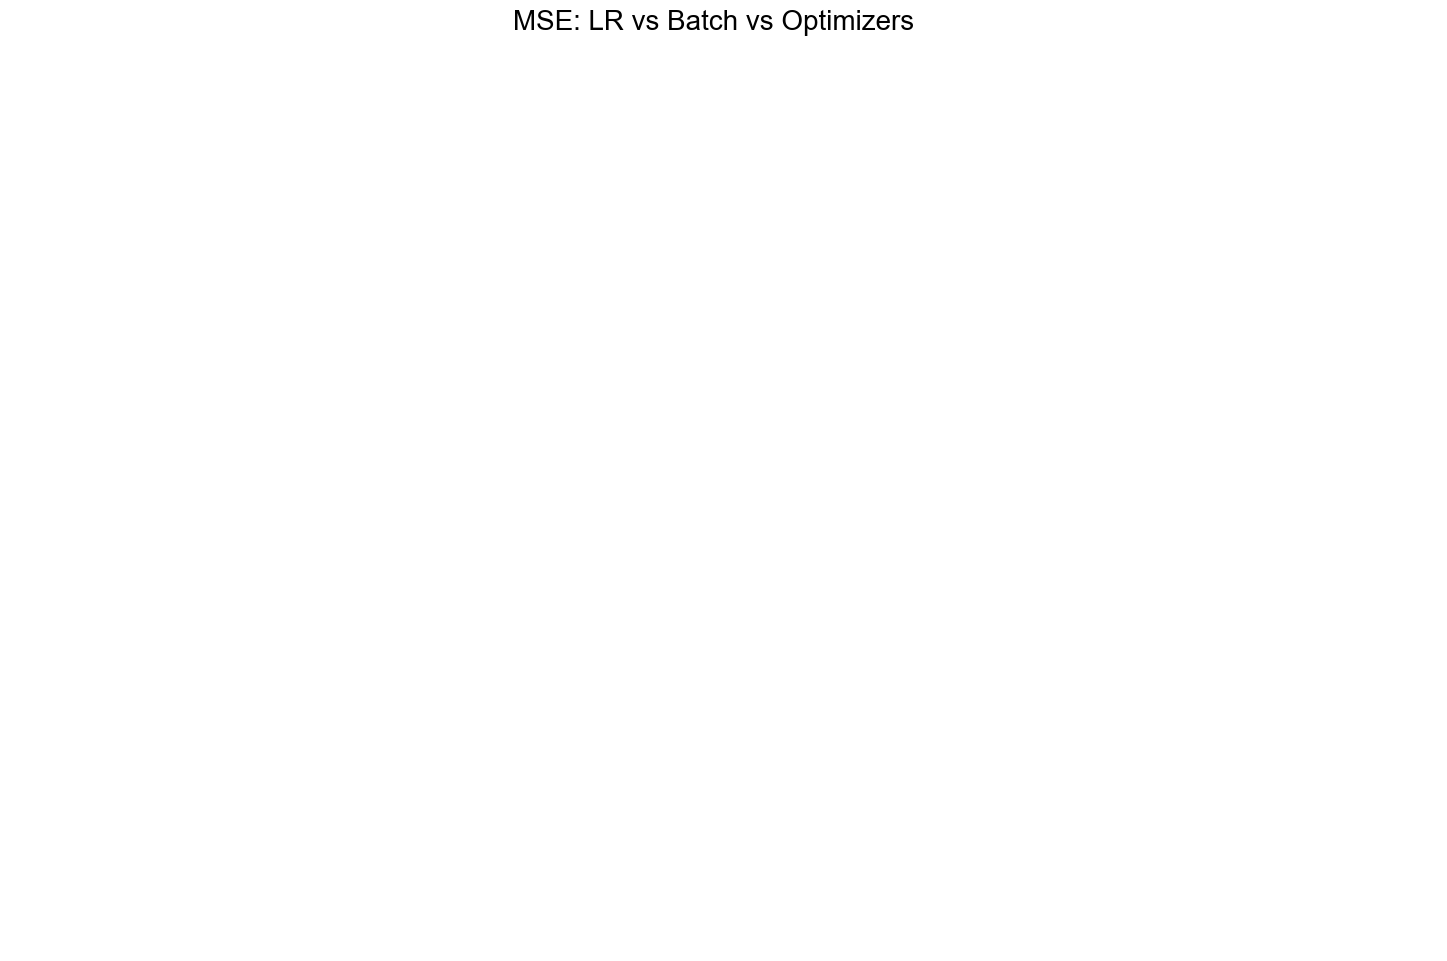

Making figure with 1 rows and 1 columns.


<Figure size 640x480 with 0 Axes>

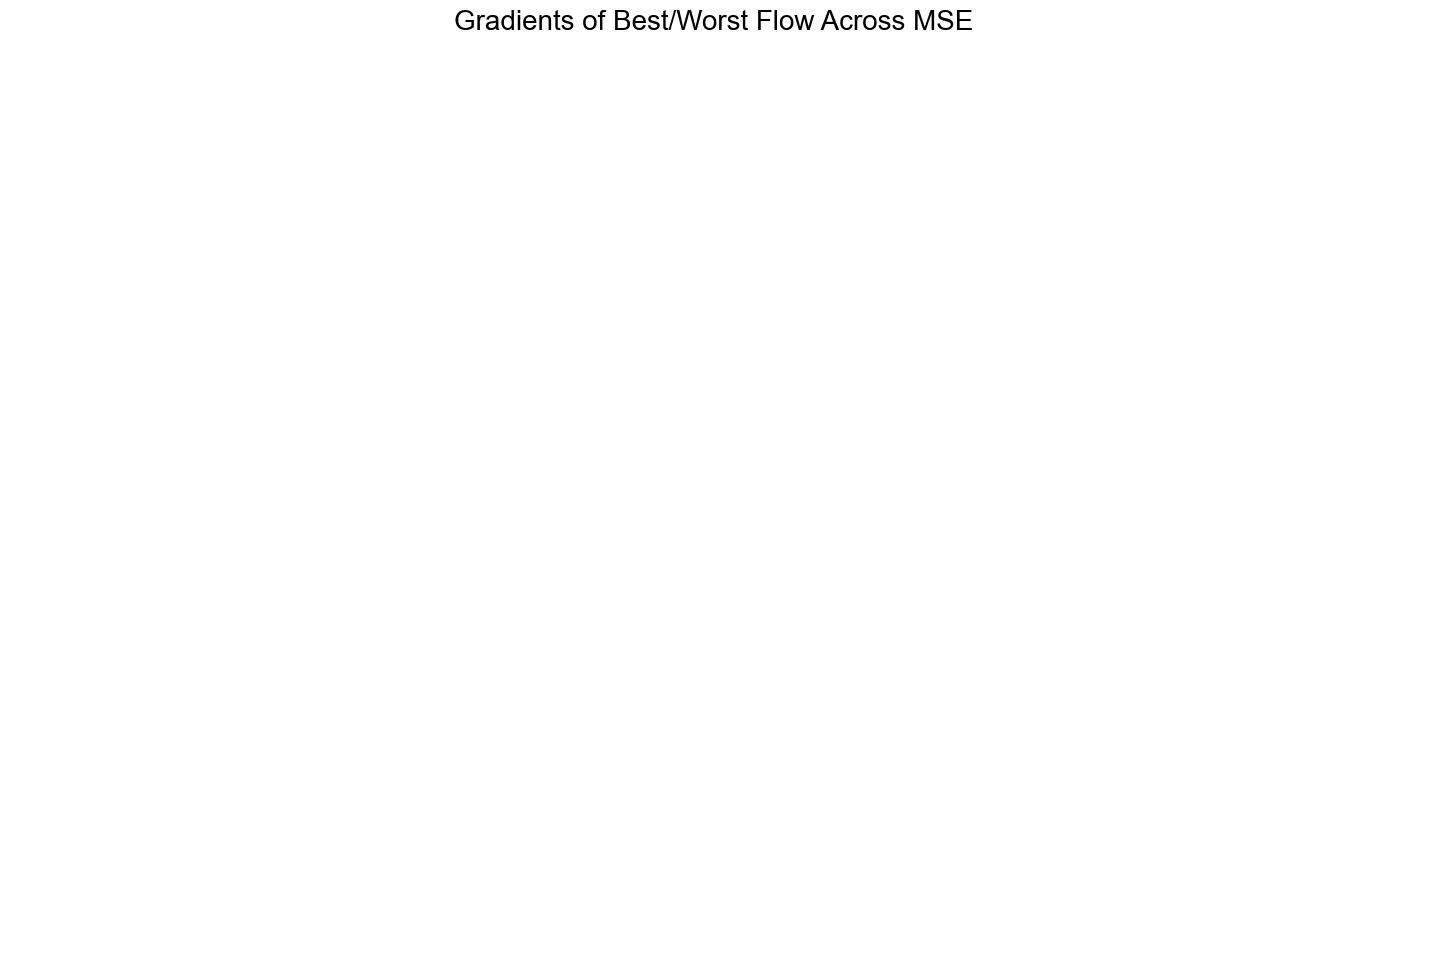

Making figure with 1 rows and 1 columns.


<Figure size 640x480 with 0 Axes>

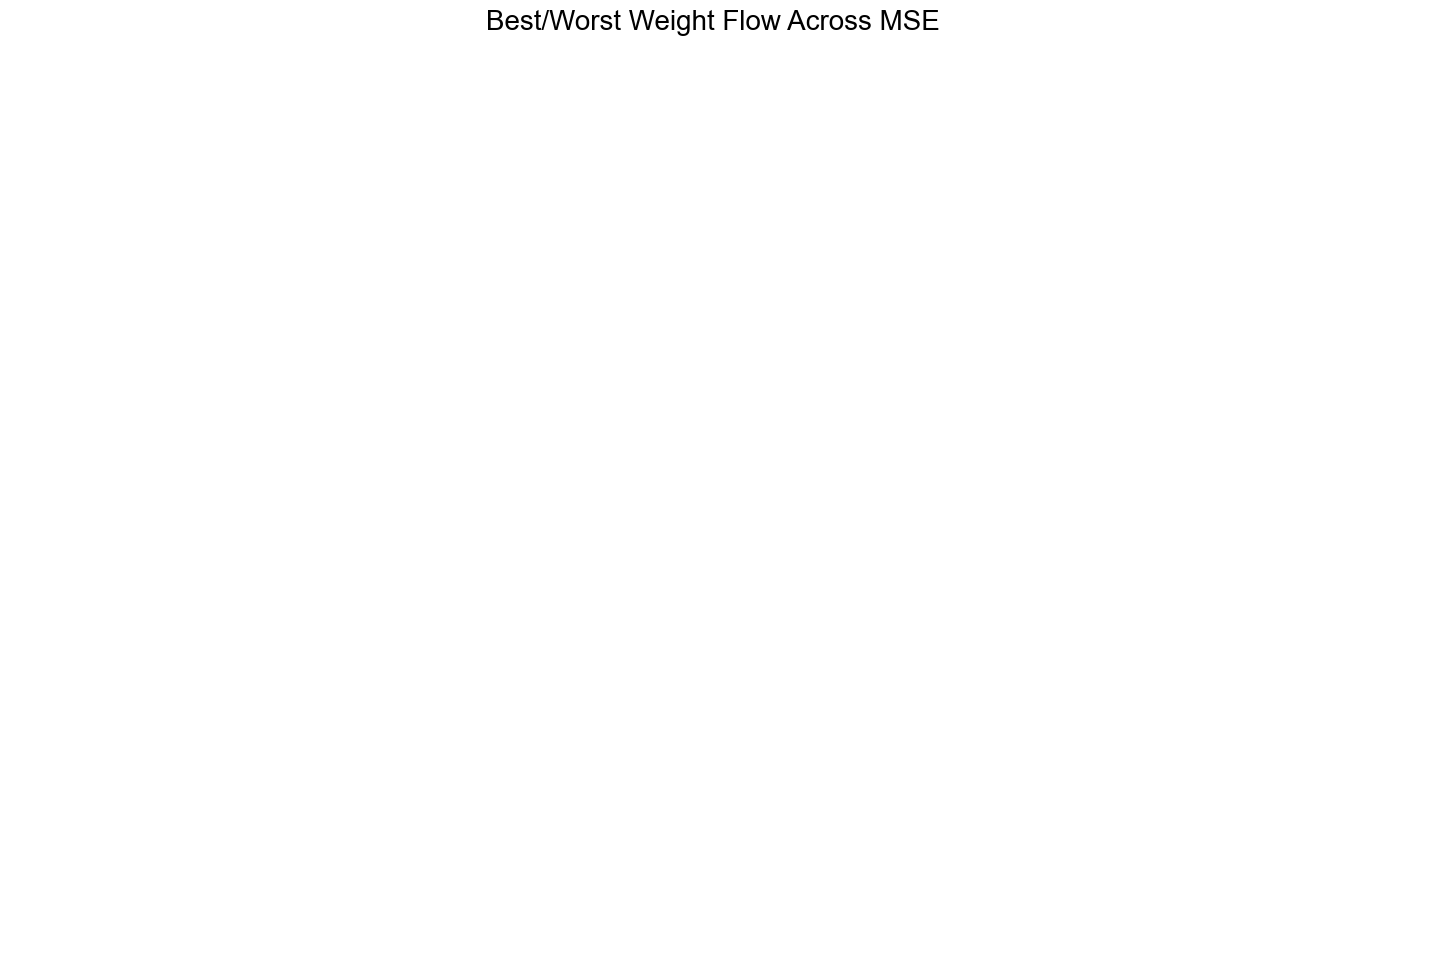

In [12]:
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title=f"MSE: LR vs Batch vs Optimizers",
                                 use_tex=False))

viz.clear_plots()
plots = expt_handler.make_lr_plots()
for plot in plots:
    viz.append_plot(plot)

viz.generate_plots()
plt.show()

# viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title=f"Loss vs Batch vs Optimizers",
#                                  use_tex=False))
# viz.clear_plots()
# plots = expt_handler.make_loss_plots()
# for plot in plots:
#     viz.append_plot(plot)
# viz.generate_plots()
# plt.show()

selected_loss = LossType.MSE
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title=f"Gradients of Best/Worst Flow Across {selected_loss.name}",
                                 use_tex=False))
viz.clear_plots()
plots, grad_plots = expt_handler.plot_best_and_worst_weight_flow(plot_type=PlotType.LINE, selected_loss=selected_loss)
for plot in grad_plots:
    viz.append_plot(plot)

viz.generate_plots()
plt.show()

viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title=f"Best/Worst Weight Flow Across {selected_loss.name}",
                                 use_tex=False))
viz.clear_plots()
for plot in plots:
    viz.append_plot(plot)

viz.generate_plots()
plt.show()

### LR Based Plots

['mean_squared_error'] [1, 32, 900] ['momentum', 'nesterov', 'sgd'] [0.001, 0.01] [0.1, 0.9]
Adding Exp_mean_squared_error_1000_1_momentum_0.001_0.1 to plots.
Adding Exp_mean_squared_error_1000_1_momentum_0.001_0.9 to plots.
Adding Exp_mean_squared_error_1000_1_nesterov_0.001_0.1 to plots.
Adding Exp_mean_squared_error_1000_1_nesterov_0.001_0.9 to plots.
Adding Exp_mean_squared_error_1000_1_sgd_0.001 to plots.
Adding Exp_mean_squared_error_1000_1_momentum_0.01_0.1 to plots.
Adding Exp_mean_squared_error_1000_1_momentum_0.01_0.9 to plots.
Adding Exp_mean_squared_error_1000_1_nesterov_0.01_0.1 to plots.
Adding Exp_mean_squared_error_1000_1_nesterov_0.01_0.9 to plots.
Adding Exp_mean_squared_error_1000_1_sgd_0.01 to plots.
Adding Exp_mean_squared_error_1000_32_momentum_0.001_0.1 to plots.
Adding Exp_mean_squared_error_1000_32_momentum_0.001_0.9 to plots.
Adding Exp_mean_squared_error_1000_32_nesterov_0.001_0.1 to plots.
Adding Exp_mean_squared_error_1000_32_nesterov_0.001_0.9 to plots.
Ad

(<Figure size 1500x700 with 9 Axes>,
 array([[<Axes: title={'center': 'LR: 0.001'}, ylabel='BATCH SIZE: 1'>,
         <Axes: title={'center': 'LR: 0.01'}>,
         <Axes: title={'center': 'LR: 1'}>],
        [<Axes: ylabel='BATCH SIZE: 32'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='Epoch', ylabel='BATCH SIZE: 900'>,
         <Axes: xlabel='Epoch'>, <Axes: xlabel='Epoch'>]], dtype=object))

<Figure size 640x480 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

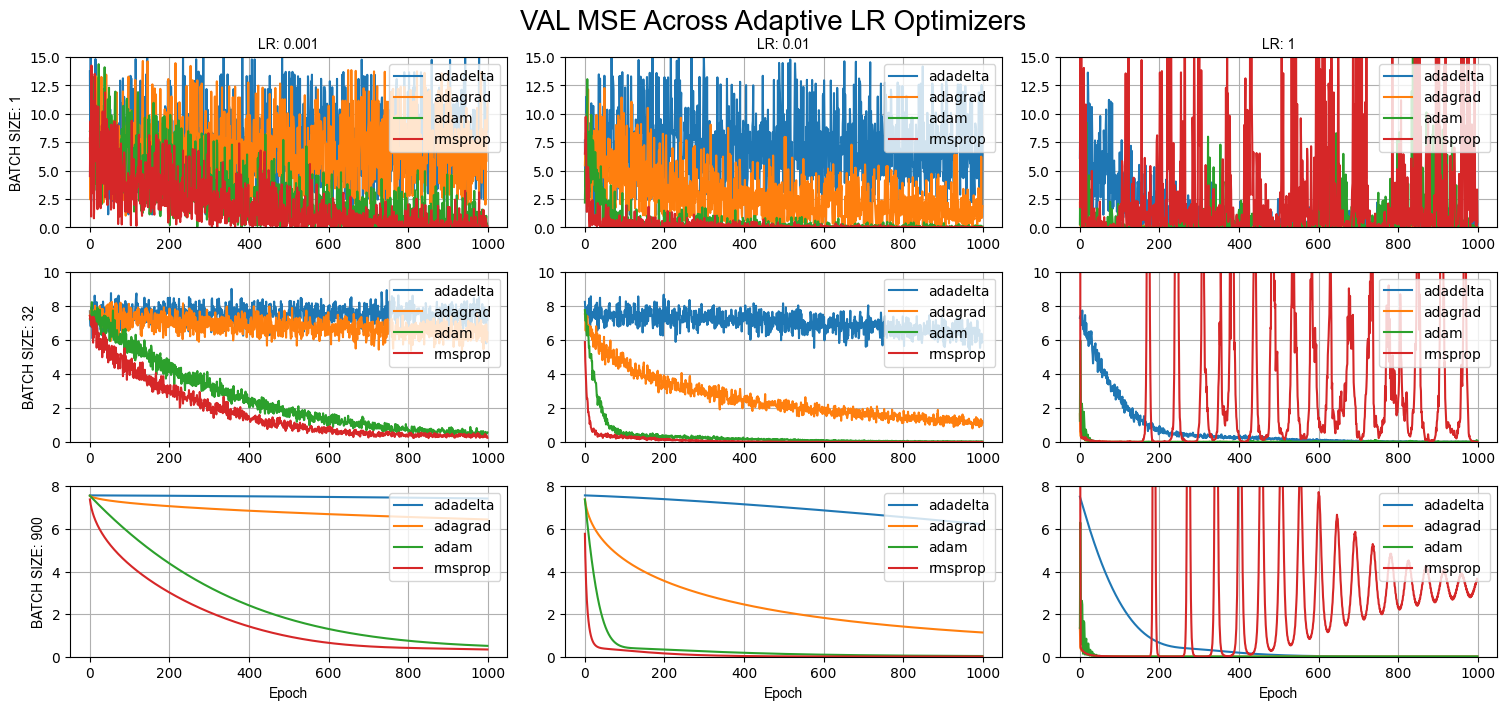

In [97]:
def make_lr_plots(self, loss:LossType = LossType.MSE, 
                  optimizers = [Optimizer.SGD, Optimizer.NESTEROV, Optimizer.MOMENTUM],
                  learning_rates:Optional[List[float]]=None)->List[Plot]:
        keys = list(visible_colors.values())
        batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
        losses = set([expt.config.loss.value for expt in self.experiments.values() if expt.config.loss.value==loss.value])
        opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        if optimizers is not None:
            opt_names = set([optimizer.value for optimizer in optimizers])
        else:
            opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        if learning_rates is None:
            learning_rates = set([expt.config.learning_rate for expt in self.experiments.values()])
        momentums = set([expt.config.momentum for expt in self.experiments.values()])

        learning_rates = sorted(learning_rates)
        momentums = sorted(momentums)
        batch_sizes=sorted(batch_sizes)
        opt_names = sorted(opt_names)
        losses = sorted(losses)

        print(losses, batch_sizes, opt_names, learning_rates, momentums)

        
        new_row = False
        new_col = False
        plots = []
        completed_expts = []

        opt_color =  []
        for b, bs in enumerate(batch_sizes):
            for l, lr in enumerate(learning_rates):
                cindex = 0                 
                for o, opt_name in enumerate(opt_names):
                    # if opt_name in [Optimizer.ADADELTA.value]:
                    #     continue
                    for mi,m in enumerate(momentums):
                        # if mi>0 and opt_name not in [Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value]:
                        #     continue
                        for expt_name, expt in self.experiments.items():
                            # if expt_name == 'Exp_mean_absolute_error_100_-1_adadelta_0.0001':
                            #     print(expt.config.batch_size, expt.config.loss, expt.config.optimizer,
                            #            expt.config.learning_rate, expt.config.momentum)
                            #     print(bs, loss, opt_name, lr, m, expt.config.batch_size == bs, 
                            #           expt.config.loss == loss, expt.config.optimizer.value == opt_name, 
                            #           expt.config.learning_rate == lr, expt.config.momentum == m, expt_name not in completed_expts)
                            
                            if (expt.config.batch_size == bs and expt.config.loss.value == loss.value and 
                            expt.config.optimizer.value == opt_name and expt.config.learning_rate == lr and 
                            expt.config.momentum == m and expt_name not in completed_expts):
                                if (opt_name, m) not in opt_color:
                                    opt_color.append((opt_name, m))
                                
                                print(f"Adding {expt_name} to plots.")

                                val_metric = np.array([m["val_loss"] for m in expt.losses.values()])
                                ylabel = f"Batch Size: {bs}"

                                if l==0:
                                    ylabel=ylabel.upper()
                                else:
                                    ylabel=""

                                if b==0:
                                    title=f'LR: {lr}'
                                else:
                                    title=""
                                
                                if b==len(batch_sizes)-1:
                                    xlabel="Epoch"
                                else:
                                    xlabel=''

                                if new_row:
                                    order = PlotOn.APPEND_DOWN
                                    new_col=False
                                    new_row=False

                                elif new_col:
                                    order = PlotOn.APPEND_RIGHT
                                    new_col=False
                                    new_row=False
                                else:
                                    order = PlotOn.RIGHT
                                    new_col=False
                                    new_row=False
                                    
                                # row.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=order, title=f'Train {loss}',legend=f"{opt_name}", color=keys[i]))
                                legend = f"{opt_name}" if opt_name not in [Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value] else f"{opt_name}({m})"
                                
                                
                                plots.append(Plot(X=np.arange(len(val_metric)), title_size=10, y=val_metric, plot_type=PlotType.LINE, 
                                                  plot_order=order, ylabel=ylabel, xlabel=xlabel, title=title,legend=legend, 
                                                  color=keys[opt_color.index((opt_name, m))]))
                                # i+=1
                                completed_expts.append(expt_name)
                                
                new_col = True
                # break
            new_row = True
            # break
                    
        return plots


expt_handler.make_lr_plots=make_lr_plots.__get__(expt_handler, ExperimentHandler)
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,7),title="VAL MSE Across Const. LR Optimizers",
                                 use_tex=False, sharey=False))
viz.clear_plots()
plots = expt_handler.make_lr_plots(loss=LossType.MSE, learning_rates=[0.001,0.01], optimizers=[Optimizer.SGD, Optimizer.MOMENTUM, Optimizer.NESTEROV])

for i,plot in enumerate(plots):
    
    viz.append_plot(plot)
    # if i>3:
    #     break
    

    plot.fixed_ymax=True
    plot.ymax=4
    if plot.plot_row_col[0] == 0:
        plot.ymax=13
    elif plot.plot_row_col[0] == 1:
        plot.ymax=8
    elif plot.plot_row_col[0] == 2:
        plot.ymax=8
    plot.ymin=0
    # plot.ymax=None
    
    plot.linewidth=1.5
    if "nesterov" in plot.legend:
        plot.linestyle='--'
    # if "sgd" in plot.legend:
    #     plot.linestyle='-.'
    plot.legend_size=10
viz.generate_plots('less_noise_const_lr_optimizers.pdf', 'pdf')

expt_handler.make_lr_plots=make_lr_plots.__get__(expt_handler, ExperimentHandler)
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,7),title="VAL MSE Across Adaptive LR Optimizers",
                                 use_tex=False, sharey=False))
viz.clear_plots()
plots = expt_handler.make_lr_plots(loss=LossType.MSE, optimizers=[Optimizer.ADAGRAD,Optimizer.RMSPROP, Optimizer.ADADELTA, Optimizer.ADAM ])
for plot in plots:
    viz.append_plot(plot)

    if plot.plot_row_col[0] == 0:
        plot.ymax=15
    elif plot.plot_row_col[0] == 1:
        plot.ymax=10
    elif plot.plot_row_col[0] == 2:
        plot.ymax=8
    plot.ymin=0
    # plot.ymax=None
    plot.linewidth=1.5
    plot.fixed_ymax=True
    plot.legend_size=10



viz.generate_plots('less_noise_var_lr_optimizers.pdf', 'pdf')

['mean_squared_error'] [1, 32, 900] ['sgd'] [0.001, 0.01, 1] [0.1, 0.9]
Adding Exp_mean_squared_error_1000_1_sgd_0.001 to plots.
Adding Exp_mean_squared_error_1000_1_sgd_0.01 to plots.
Adding Exp_mean_squared_error_1000_1_sgd_1 to plots.
Adding Exp_mean_squared_error_1000_32_sgd_0.001 to plots.
Adding Exp_mean_squared_error_1000_32_sgd_0.01 to plots.
Adding Exp_mean_squared_error_1000_32_sgd_1 to plots.
Adding Exp_mean_squared_error_1000_-1_sgd_0.001 to plots.
Adding Exp_mean_squared_error_1000_-1_sgd_0.01 to plots.
Adding Exp_mean_squared_error_1000_-1_sgd_1 to plots.
Making figure with 3 rows and 3 columns.
['mean_squared_error'] [1, 32, 900] ['momentum'] [0.001, 0.01, 1] [0.1, 0.9]
Adding Exp_mean_squared_error_1000_1_momentum_0.001_0.1 to plots.
Adding Exp_mean_squared_error_1000_1_momentum_0.001_0.9 to plots.
Adding Exp_mean_squared_error_1000_1_momentum_0.01_0.1 to plots.
Adding Exp_mean_squared_error_1000_1_momentum_0.01_0.9 to plots.
Adding Exp_mean_squared_error_1000_1_momentu

<Figure size 640x480 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

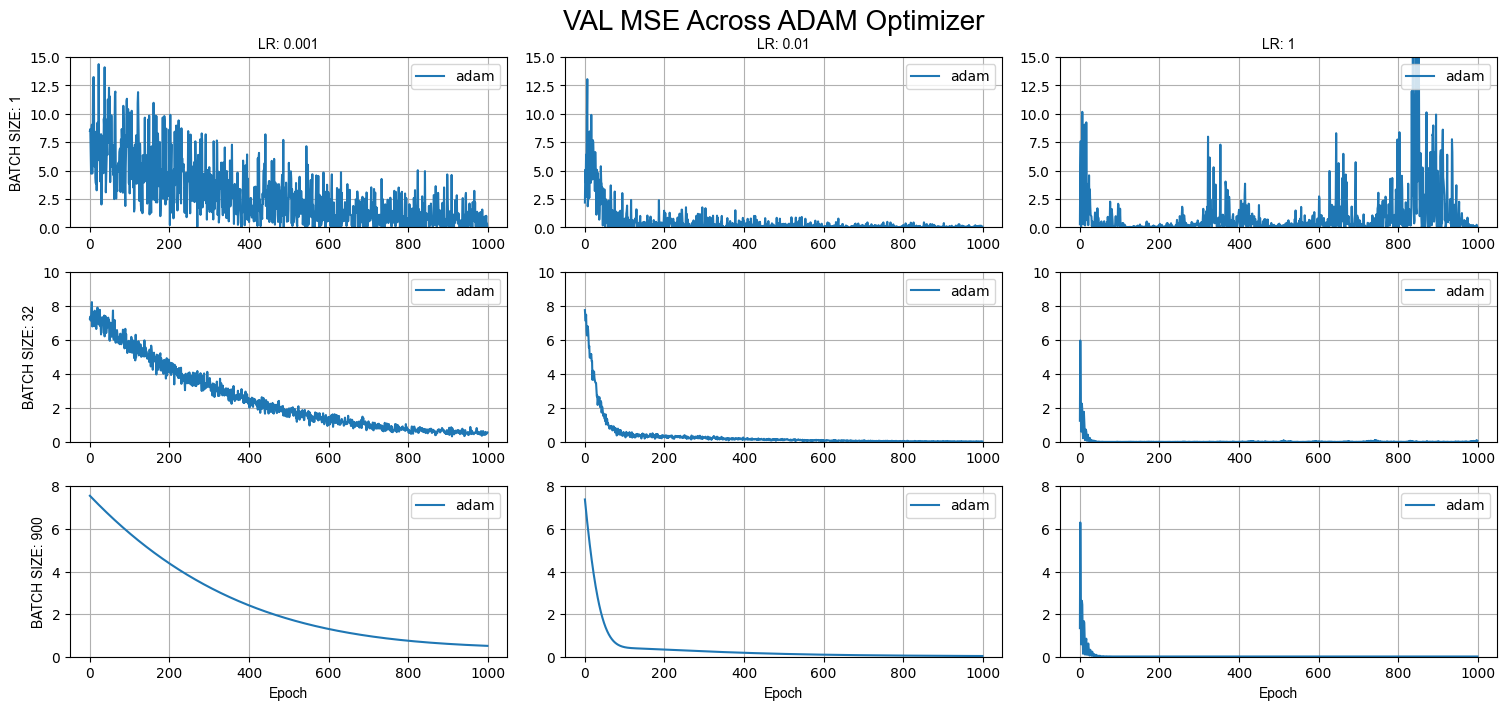

In [81]:

for optimizer in [Optimizer.SGD, Optimizer.MOMENTUM, Optimizer.NESTEROV,Optimizer.ADAGRAD,Optimizer.RMSPROP, Optimizer.ADADELTA, Optimizer.ADAM ]:
    viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,7),title=f"VAL MSE Across {optimizer.name} Optimizer",
                                 use_tex=False, sharey=False))
    viz.clear_plots()
    plots = expt_handler.make_lr_plots(loss=LossType.MSE,optimizers = [optimizer])

    for i,plot in enumerate(plots):
        
        viz.append_plot(plot)   

        plot.fixed_ymax=True
        plot.ymax=4
        if plot.plot_row_col[0] == 0:
            plot.ymax=15
        elif plot.plot_row_col[0] == 1:
            plot.ymax=10
        elif plot.plot_row_col[0] == 2:
            plot.ymax=8
        plot.ymin=0
        plot.linewidth=1.5
        # plot.ymax=None
        plot.legend_size=10
    viz.generate_plots(f'{optimizer.name}.pdf', 'pdf')
    # break

['mean_squared_error'] [1, 32, 900] ['adam', 'nesterov'] [0.001, 0.01, 1] [0.1, 0.9]
Adding Exp_mean_squared_error_1000_1_adam_0.001 to plots.
Adding Exp_mean_squared_error_1000_1_nesterov_0.001_0.1 to plots.
Adding Exp_mean_squared_error_1000_1_nesterov_0.001_0.9 to plots.
Adding Exp_mean_squared_error_1000_1_adam_0.01 to plots.
Adding Exp_mean_squared_error_1000_1_nesterov_0.01_0.1 to plots.
Adding Exp_mean_squared_error_1000_1_nesterov_0.01_0.9 to plots.
Adding Exp_mean_squared_error_1000_1_adam_1 to plots.
Adding Exp_mean_squared_error_1000_1_nesterov_1_0.1 to plots.
Adding Exp_mean_squared_error_1000_1_nesterov_1_0.9 to plots.
Adding Exp_mean_squared_error_1000_32_adam_0.001 to plots.
Adding Exp_mean_squared_error_1000_32_nesterov_0.001_0.1 to plots.
Adding Exp_mean_squared_error_1000_32_nesterov_0.001_0.9 to plots.
Adding Exp_mean_squared_error_1000_32_adam_0.01 to plots.
Adding Exp_mean_squared_error_1000_32_nesterov_0.01_0.1 to plots.
Adding Exp_mean_squared_error_1000_32_neste

(<Figure size 2000x700 with 9 Axes>,
 array([[<Axes: title={'center': 'LR: 0.001'}, ylabel='BATCH SIZE: 1'>,
         <Axes: title={'center': 'LR: 0.01'}>,
         <Axes: title={'center': 'LR: 1'}>],
        [<Axes: ylabel='BATCH SIZE: 32'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='Epoch', ylabel='BATCH SIZE: 900'>,
         <Axes: xlabel='Epoch'>, <Axes: xlabel='Epoch'>]], dtype=object))

<Figure size 640x480 with 0 Axes>

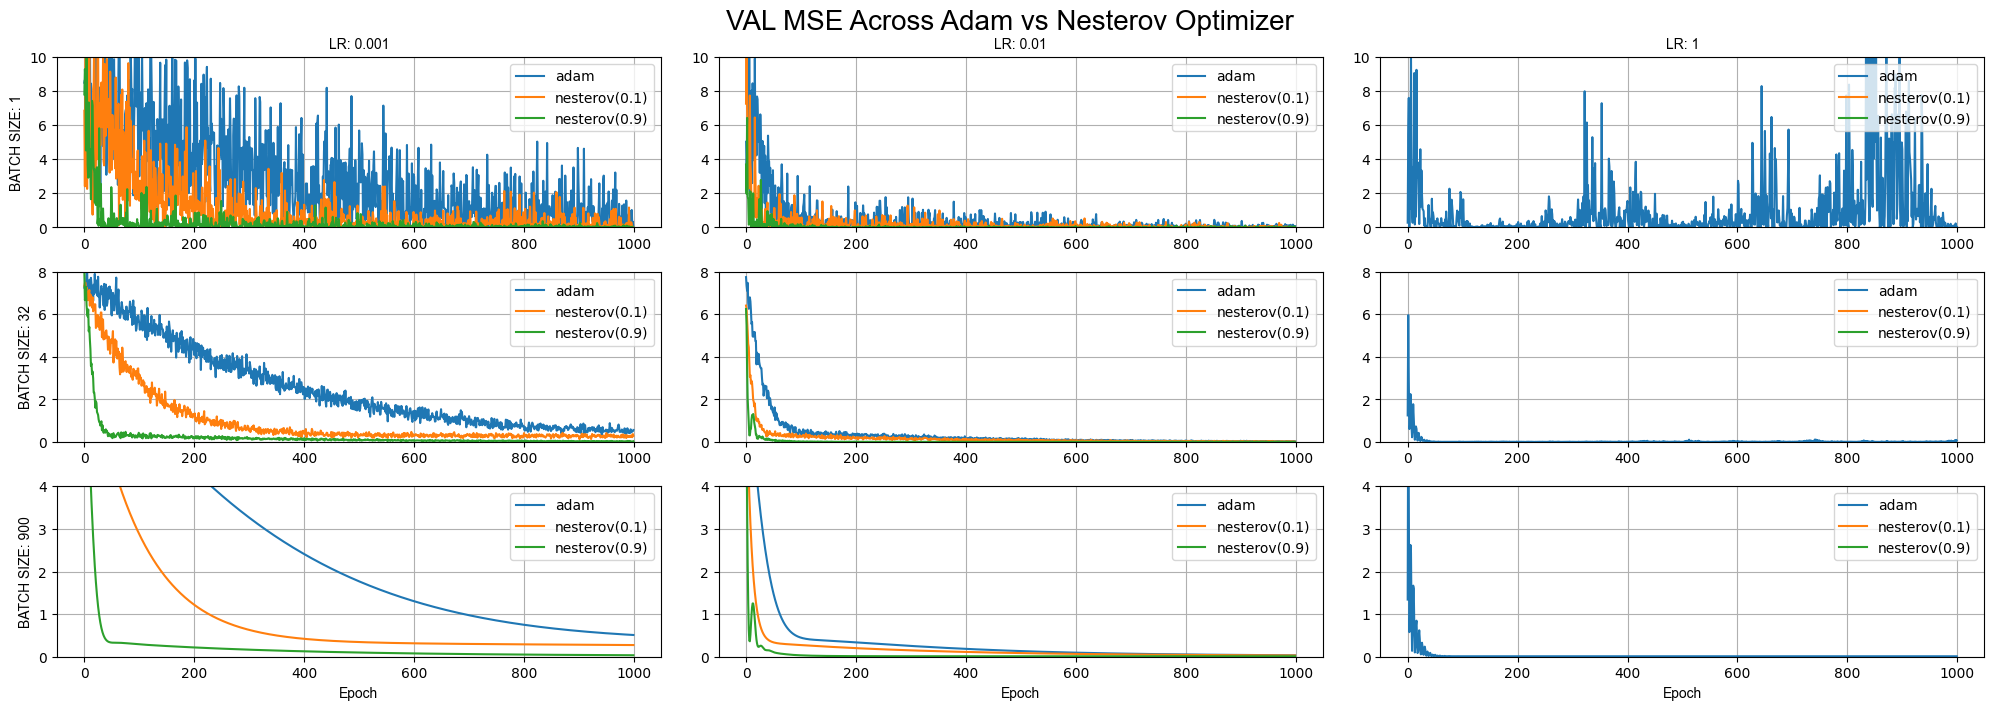

In [104]:
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(20,7),title=f"VAL MSE Across Adam vs Nesterov Optimizer",
                                use_tex=False, sharey=False))
viz.clear_plots()
plots = expt_handler.make_lr_plots(loss=LossType.MSE, optimizers = [Optimizer.NESTEROV,Optimizer.ADAM ])
for i,plot in enumerate(plots):
    # print(plot)
    
    viz.append_plot(plot)   

    plot.fixed_ymax=True
    plot.ymax=4
    if plot.plot_row_col[0] == 0:
        plot.ymax=10
    elif plot.plot_row_col[0] == 1:
        plot.ymax=8
    elif plot.plot_row_col[0] == 2:
        plot.ymax=4
    plot.ymin=0
    # plot.X=plot.X[200:]
    # plot.y=plot.y[200:]
    plot.linewidth=1.5
    # plot.ymax=None
    plot.legend_size=10
viz.generate_plots('nestertov_adam.pdf', 'pdf')

In [70]:
plot.linewidth

2

### Loss Plots

['mean_squared_error'] [1, 32, 900] ['sgd']
Adding Exp_mean_squared_error_1000_1_sgd_0.001 to plots.
Adding Exp_mean_squared_error_1000_1_sgd_0.01 to plots.
Adding Exp_mean_squared_error_1000_1_sgd_1 to plots.
Adding Exp_mean_squared_error_1000_32_sgd_0.001 to plots.
Adding Exp_mean_squared_error_1000_32_sgd_0.01 to plots.
Adding Exp_mean_squared_error_1000_32_sgd_1 to plots.
Adding Exp_mean_squared_error_1000_-1_sgd_0.001 to plots.
Adding Exp_mean_squared_error_1000_-1_sgd_0.01 to plots.
Adding Exp_mean_squared_error_1000_-1_sgd_1 to plots.
Making figure with 1 rows and 3 columns.


<Figure size 640x480 with 0 Axes>

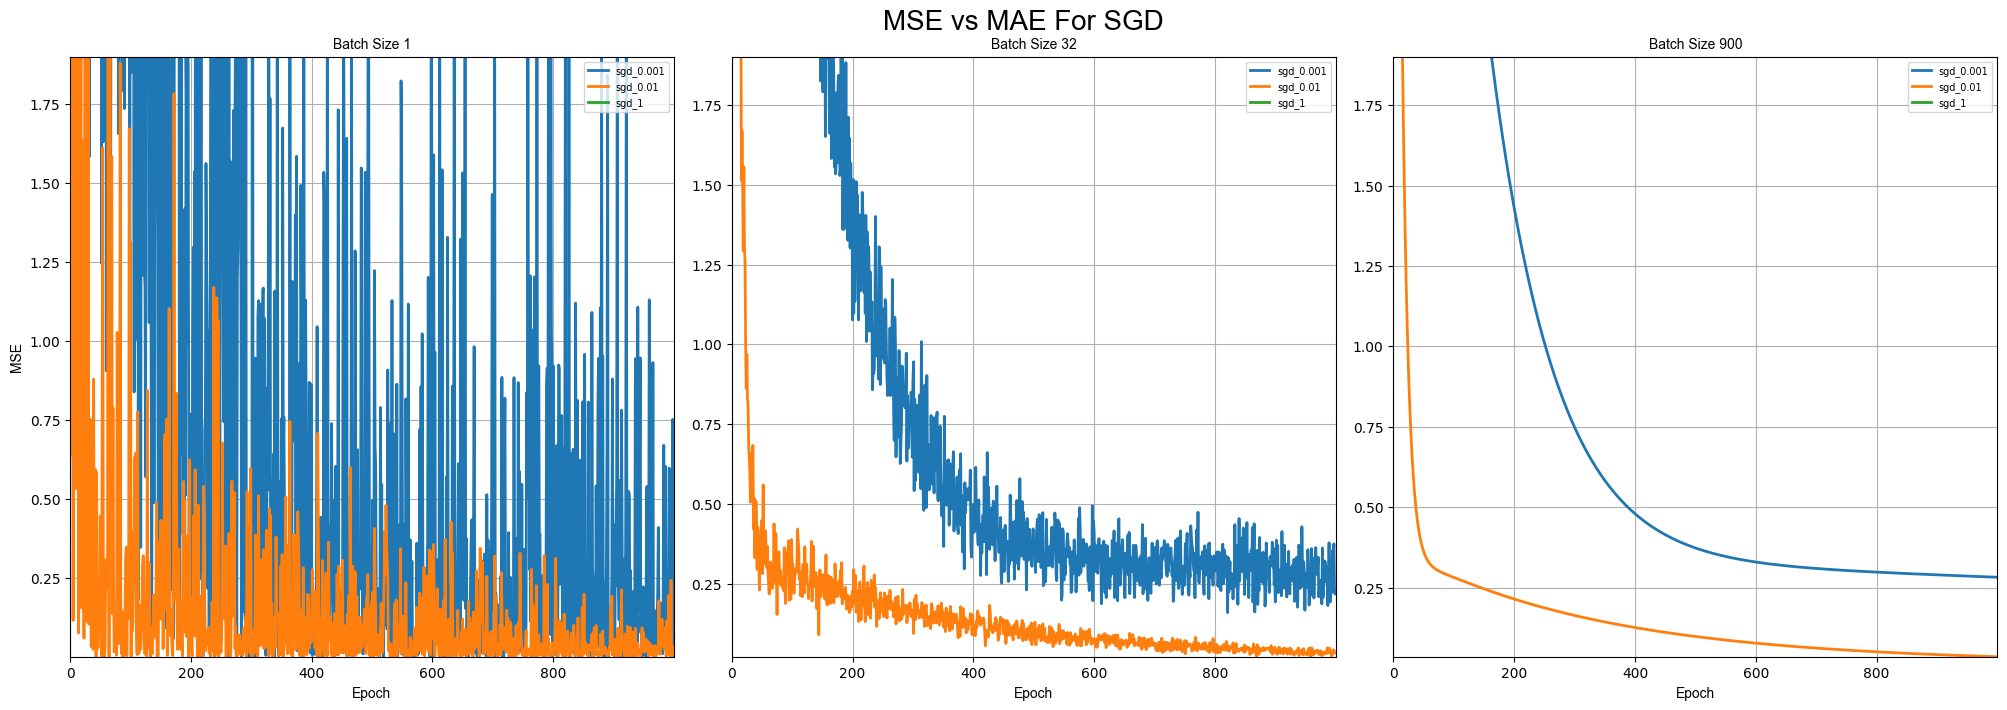

In [15]:
def make_loss_plots(self, metric:str='val_loss', momentum:float=0.1,
                    optimizers=[Optimizer.SGD])->List[Plot]:
        keys = list(visible_colors.values())
        batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
        losses = set([expt.config.loss.value for expt in self.experiments.values()])
        if len(optimizers)==0:
            opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        else:
            opt_names = [opt.value for opt in optimizers]
        learning_rates = set([expt.config.learning_rate for expt in self.experiments.values()])
        momentums = set([expt.config.momentum for expt in self. experiments.values() if expt.config.momentum==momentum])
        
        batch_sizes=sorted(batch_sizes)
        opt_names = sorted(opt_names)
        losses = sorted(losses)
        learning_rates = sorted(learning_rates)
        momentums = sorted(momentums)

        print(losses, batch_sizes, opt_names)
        
        new_row = False
        new_col = False
        plots = []
        completed_expts = []
        
        for l, loss in enumerate(losses):
            for b, bs in enumerate(batch_sizes):
                ind=0
                for o,opt_name in enumerate(opt_names):
                    for expt_name, expt in self.experiments.items():
                        for lr,learning_rate in enumerate(learning_rates):
                            for mi,momentum in enumerate(momentums):
                                if opt_name in [Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value] and mi>0:
                                    continue
                                if expt.config.batch_size == bs and expt.config.loss.value == loss and expt.config.optimizer.value == opt_name and expt_name not in completed_expts and expt.config.momentum == momentum and \
                                    expt.config.learning_rate==learning_rate:
                                    print(f"Adding {expt_name} to plots.")

                                    val_metric = np.array([m[metric] for m in expt.losses.values()])
                                    ylabel = "".join([l[0] for l in loss.split("_")])

                                    if b==0:
                                        ylabel=ylabel.upper()
                                    else:
                                        ylabel=""

                                    if l==0:
                                        title=f'Batch Size {bs}'
                                    else:
                                        title=""
                                    
                                    if l==len(losses)-1:
                                        xlabel="Epoch"
                                    else:
                                        xlabel=''

                                    if new_row:
                                        order = PlotOn.APPEND_DOWN
                                        new_col=False
                                        new_row=False

                                    elif new_col:
                                        order = PlotOn.APPEND_RIGHT
                                        new_col=False
                                        new_row=False
                                    else:
                                        order = PlotOn.RIGHT
                                        new_col=False
                                        new_row=False
                                        
                                    # row.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=order, title=f'Train {loss}',legend=f"{opt_name}", color=keys[i]))
                                    legend = f"{opt_name}_{learning_rate}_{momentum}" if opt_name in [Optimizer.NESTEROV.value, Optimizer.MOMENTUM.value] else f"{opt_name}_{learning_rate}"
                                    plots.append(Plot(X=np.arange(len(val_metric)), title_size=10, y=val_metric, plot_type=PlotType.LINE, plot_order=order, ylabel=ylabel, xlabel=xlabel, title=title,legend=legend, color=keys[ind]))
                                    ind+=1
                                    # i+=1
                                    completed_expts.append(expt_name)
                            
                new_col = True
            new_row = True
        
        # only show title for first row of plots
            
        return plots


expt_handler.make_loss_plots=make_loss_plots.__get__(expt_handler, ExperimentHandler)
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(20,7),title="MSE vs MAE For SGD",
                                 use_tex=False, sharey=False))
viz.clear_plots()
plots = expt_handler.make_loss_plots()
# get ymax from all plots
ymax = max([max(plot.y) for plot in plots])
for plot in plots:
    viz.append_plot(plot)
    # plot.fixed_ymax=True
    plot.bottom_margin=0.0
    plot.apply_margin=True
    plot.ymax=1
    

fig,axes = viz.generate_plots('less_noise_sgd_mse_mae.pdf', 'pdf')

### Best Worst Weight Flow

['mean_squared_error'] [1, 32, 900] ['adadelta', 'adagrad', 'adam', 'rmsprop']
Best model For optimizer adadelta: BS: 1 with loss 1.9854326183121884e-06.
Worst model For optimizer adadelta: BS: 900 with loss 7.428953647613525.
Best model For optimizer adagrad: BS: 1 with loss 2.793291287161992e-08.
Worst model For optimizer adagrad: BS: 900 with loss 6.444473743438721.
Best model For optimizer adam: BS: 1 with loss 1.8828814063454047e-09.
Worst model For optimizer adam: BS: 900 with loss 0.5102372765541077.
Best model For optimizer rmsprop: BS: 1 with loss 3.3015226108545903e-09.
Worst model For optimizer rmsprop: BS: 900 with loss 0.33971449732780457.
Making figure with 4 rows and 2 columns.


<Figure size 640x480 with 0 Axes>

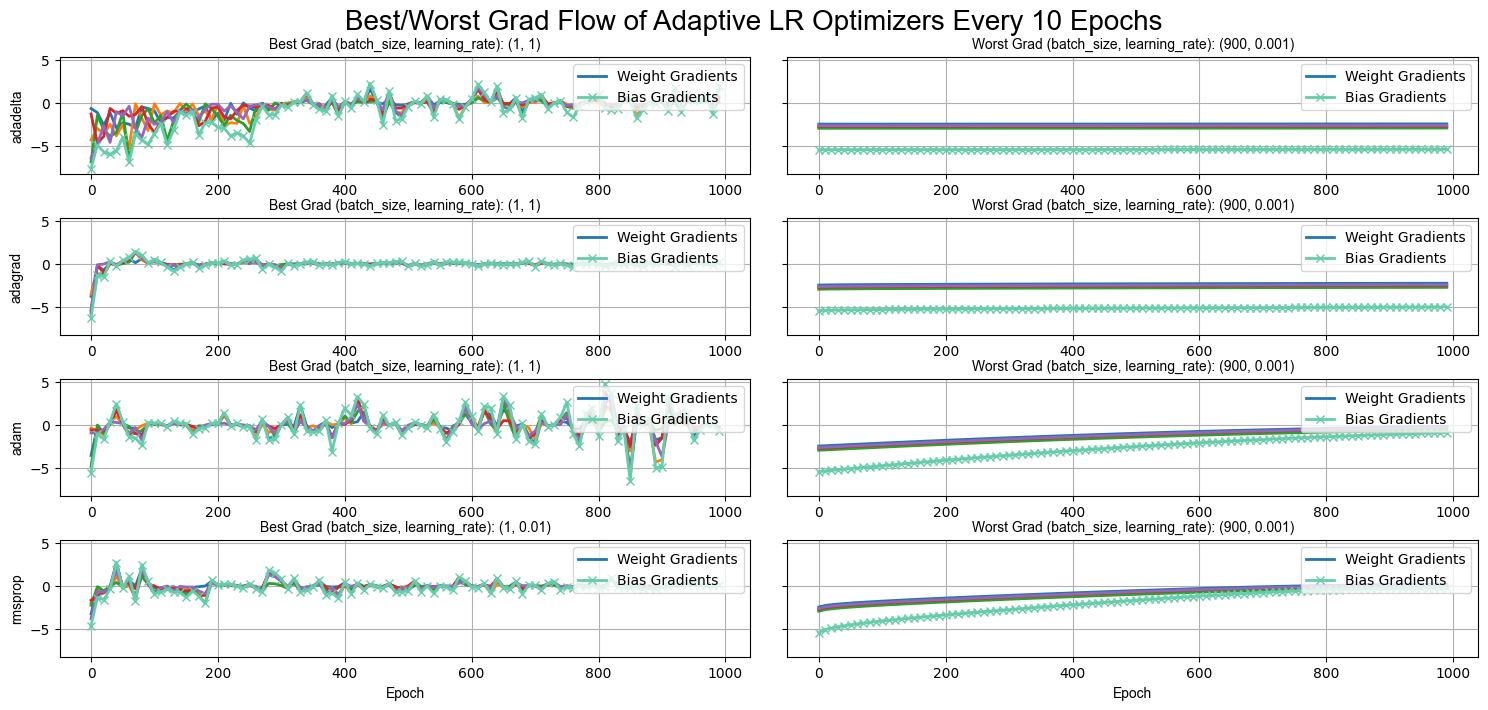

Making figure with 4 rows and 3 columns.


(<Figure size 1500x700 with 12 Axes>,
 array([[<Axes: title={'center': 'Best Param (batch_size, learning_rate): (1, 1)'}, ylabel='adadelta'>,
         <Axes: title={'center': 'Real Parameters'}>,
         <Axes: title={'center': 'Worst Param (batch_size, learning_rate): (900, 0.001)'}>],
        [<Axes: title={'center': 'Best Param (batch_size, learning_rate): (1, 1)'}, ylabel='adagrad'>,
         <Axes: >,
         <Axes: title={'center': 'Worst Param (batch_size, learning_rate): (900, 0.001)'}>],
        [<Axes: title={'center': 'Best Param (batch_size, learning_rate): (1, 1)'}, ylabel='adam'>,
         <Axes: >,
         <Axes: title={'center': 'Worst Param (batch_size, learning_rate): (900, 0.001)'}>],
        [<Axes: title={'center': 'Best Param (batch_size, learning_rate): (1, 0.01)'}, xlabel='Epoch', ylabel='rmsprop'>,
         <Axes: >,
         <Axes: title={'center': 'Worst Param (batch_size, learning_rate): (900, 0.001)'}, xlabel='Epoch'>]],
       dtype=object))

<Figure size 640x480 with 0 Axes>

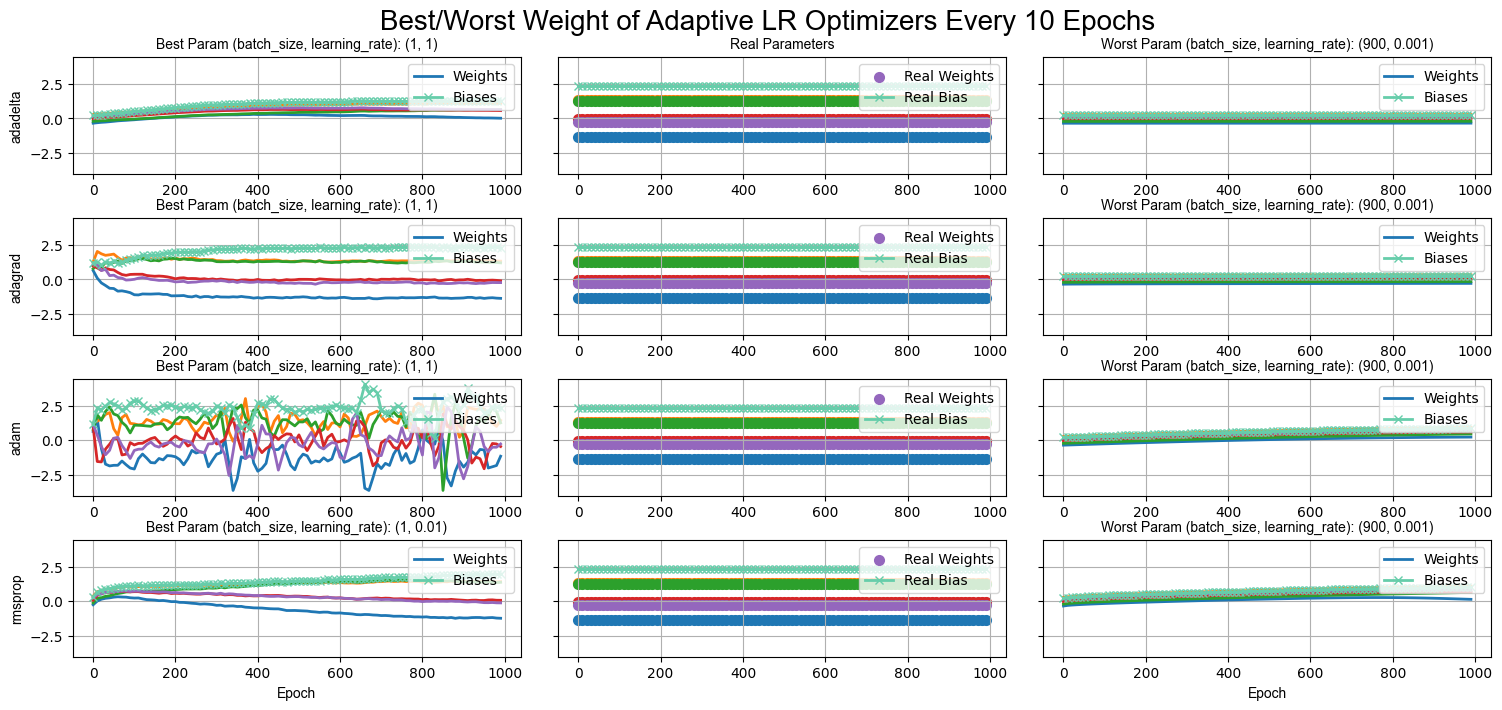

In [16]:
def plot_best_and_worst_weight_flow(
    self,
    selected_loss: LossType = LossType.MSE,
    plot_type: PlotType = PlotType.SCATTER,
    filter_optimizers: List[str] = [], 
    # learning_rate: float = 0.01,
    # interval: int = 20,
) -> List[Plot]:
    colors = list(visible_colors.values())
    batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
    losses = set(
        [
            expt.config.loss.value
            for expt in self.experiments.values()
            if expt.config.loss.value == selected_loss.value
        ]
    )
    opt_names = set([expt.config.optimizer.value for expt in self.experiments.values() if expt.config.optimizer.value not in filter_optimizers])
    learning_rates = set(
        [expt.config.learning_rate for expt in self.experiments.values()]
    )
    batch_sizes = sorted(batch_sizes)
    opt_names = sorted(opt_names)
    losses = sorted(losses)

    print(losses, batch_sizes, opt_names)
    plots = []
    grad_plots = []

    # loop across all combinations and find best model for each loss function

    po = -1
    for o, opt_name in enumerate(opt_names):
        best_expt = None
        best_loss = np.inf
        worst_expt = None
        worst_loss = -np.inf

        best_weights_plots = []
        worst_weights_plots = []

        best_gradients_plots = []
        worst_gradients_plots = []

        bs = 0
        expt_name = None
        for learning_rate in learning_rates:
            for m in [0.1, 0.9]:
                for l, loss in enumerate(losses):
                    for b, bs in enumerate(batch_sizes):
                        for expt_name, expt in self.experiments.items():
                            if (
                                m==expt.config.momentum and
                                expt.config.batch_size == bs
                                and expt.config.loss.value == loss
                                and expt.config.optimizer.value == opt_name
                                and expt.config.learning_rate == learning_rate
                            ):
                                val_loss = np.array(
                                    [m["val_loss"] for m in expt.losses.values()]
                                ).min()
                                if val_loss < best_loss:
                                    best_loss = val_loss
                                    best_expt = expt_name
                                if val_loss > worst_loss:
                                    worst_loss = val_loss
                                    worst_expt = expt_name

        if expt_name is None:
            continue

        

        best_expt = self.experiments[best_expt]
        worst_expt = self.experiments[worst_expt]
        print(
            f"Best model For optimizer {opt_name}: BS: {best_expt.config.batch_size} with loss {best_loss}."
        )
        print(
            f"Worst model For optimizer {opt_name}: BS: {worst_expt.config.batch_size} with loss {worst_loss}."
        )
        epochs = np.array(best_expt.train_runner.logs["epochs"])
        best_weights = np.array(best_expt.train_runner.logs["weights"]).reshape(
            len(epochs), -1
        )
        best_biases = np.array(best_expt.train_runner.logs["biases"]).reshape(
            len(epochs), -1
        )
        best_weight_gradients = np.array(
            best_expt.train_runner.logs["weight_gradients"]
        ).reshape(len(epochs), -1)
        best_bias_gradients = np.array(
            best_expt.train_runner.logs["bias_gradients"]
        ).reshape(len(epochs), -1)

        worst_weights = np.array(worst_expt.train_runner.logs["weights"]).reshape(
            len(epochs), -1
        )
        worst_biases = np.array(worst_expt.train_runner.logs["biases"]).reshape(
            len(epochs), -1
        )
        worst_weight_gradients = np.array(
            worst_expt.train_runner.logs["weight_gradients"]
        ).reshape(len(epochs), -1)
        worst_bias_gradients = np.array(
            worst_expt.train_runner.logs["bias_gradients"]
        ).reshape(len(epochs), -1)

        real_weights = best_expt.real_weights
        real_biases = best_expt.real_biases
        real_weights_plots = []

        for widx in range(best_weights.shape[1]):
            best_weight = best_weights[:, widx].flatten()
            best_gradient = best_weight_gradients[:, widx].flatten()
            worst_weight = worst_weights[:, widx].flatten()
            worst_gradient = worst_weight_gradients[:, widx].flatten()
            color = colors[len(colors) % (widx + 1)]

            best_weights_plots.append(
                Plot(
                    X=epochs,
                    y=best_weight,
                    plot_type=plot_type,
                    plot_order=PlotOn.RIGHT,
                    color=color,
                )
            )
            worst_weights_plots.append(
                Plot(
                    X=epochs,
                    y=worst_weight,
                    plot_type=plot_type,
                    plot_order=PlotOn.RIGHT,
                    color=color,
                )
            )
            real_weights_plots.append(
                Plot(
                    X=epochs,
                    y=real_weights[widx] * np.ones_like(epochs),
                    plot_type=PlotType.SCATTER,
                    plot_order=PlotOn.RIGHT,
                    color=color,
                    allow_animation=False,
                )
            )

            best_gradients_plots.append(
                Plot(
                    X=epochs,
                    y=best_gradient,
                    plot_type=plot_type,
                    plot_order=PlotOn.RIGHT,
                    color=color,
                )
            )
            worst_gradients_plots.append(
                Plot(
                    X=epochs,
                    y=worst_gradient,
                    plot_type=plot_type,
                    plot_order=PlotOn.RIGHT,
                    color=color,
                )
            )

        bc = colors[len(colors) - 1]
        best_wt_title = (
            f"Best Param (batch_size, learning_rate): {best_expt.config.batch_size, best_expt.config.learning_rate}"
            if opt_name not in [Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value]
            else f"Best Param (batch_size, learning_rate, momentum): {best_expt.config.batch_size, best_expt.config.learning_rate, best_expt.config.momentum}"
        )
        worst_wt_title = (
            f"Worst Param (batch_size, learning_rate): {worst_expt.config.batch_size, worst_expt.config.learning_rate}"
            if opt_name not in [Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value]
            else f"Worst Param (batch_size, learning_rate, momentum) {worst_expt.config.batch_size, worst_expt.config.learning_rate, worst_expt.config.momentum}"
        )
        best_grad_title = (
            f"Best Grad (batch_size, learning_rate): {best_expt.config.batch_size, best_expt.config.learning_rate}"
            if opt_name not in [Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value]
            else f"Best Grad (batch_size, learning_rate, momentum): {best_expt.config.batch_size, best_expt.config.learning_rate, best_expt.config.momentum}"
        )
        worst_grad_title = (
            f"Worst Grad (batch_size, learning_rate): {worst_expt.config.batch_size, worst_expt.config.learning_rate}"
            if opt_name not in [Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value]
            else f"Worst Grad (batch_size, learning_rate, momentum): {worst_expt.config.batch_size, worst_expt.config.learning_rate, worst_expt.config.momentum}"
        )

        best_weights_plots.extend(
            [
                Plot(
                    X=epochs,
                    y=[b.flatten() for b in best_biases],
                    plot_type=plot_type,
                    plot_order=PlotOn.RIGHT,
                    title_size=10,
                    title=best_wt_title,
                    color=bc,
                    marker="x",
                ),
            ]
        )
        worst_weights_plots.extend(
            [
                Plot(
                    X=epochs,
                    y=[b.flatten() for b in worst_biases],
                    plot_type=plot_type,
                    plot_order=PlotOn.RIGHT,
                    title_size=10,
                    title=worst_wt_title,
                    color=bc,
                    marker="x",
                ),
            ]
        )
        best_gradients_plots.extend(
            [
                Plot(
                    X=epochs,
                    y=[bg.flatten() for bg in best_bias_gradients],
                    plot_type=plot_type,
                    plot_order=PlotOn.RIGHT,
                    title_size=10,
                    title=best_grad_title,
                    legend="Bias Gradients",
                    color=bc,
                    marker="x",
                ),
            ]
        )
        worst_gradients_plots.extend(
            [
                Plot(
                    X=epochs,
                    y=[bg.flatten() for bg in worst_bias_gradients],
                    plot_type=plot_type,
                    plot_order=PlotOn.RIGHT,
                    title_size=10,
                    title=worst_grad_title,
                    legend="Bias Gradients",
                    color=bc,
                    marker="x",
                ),
            ]
        )

        best_weights_plots[-1].legend = "Biases"
        best_weights_plots[0].legend = "Weights"

        worst_weights_plots[-1].legend = "Biases"
        worst_weights_plots[0].legend = "Weights"

        best_gradients_plots[0].legend = "Weight Gradients"
        worst_gradients_plots[0].legend = "Weight Gradients"

        real_weights_plots[-1].legend = "Real Weights"

        real_weights_plots[0].plot_order = PlotOn.APPEND_RIGHT
        real_weights_plots.append(
            Plot(
                X=epochs,
                y=real_biases[0]*np.ones_like(epochs),
                plot_type=plot_type,
                plot_order=PlotOn.RIGHT,
                legend="Real Bias",
                # linewidth=10,
                title_size=10,
                marker="x",
                color=colors[len(colors) - 1],
                allow_animation=False,
            )
        )

        worst_weights_plots[0].plot_order = PlotOn.APPEND_RIGHT
        worst_gradients_plots[0].plot_order = PlotOn.APPEND_RIGHT

        if po != o:
            best_weights_plots[0].plot_order = PlotOn.APPEND_DOWN
            best_weights_plots[-1].ylabel = opt_name
            best_gradients_plots[0].plot_order = PlotOn.APPEND_DOWN
            best_gradients_plots[-1].ylabel = opt_name
        if o == 0:
            # worst_weights_plots[-1].title='Worst Parameters'
            # best_weights_plots[-1].title='Best Parameters'
            real_weights_plots[-1].title = "Real Parameters"
        if o == len(opt_names) - 1:
            worst_weights_plots[-1].xlabel = "Epoch"
            best_weights_plots[-1].xlabel = "Epoch"
            best_gradients_plots[-1].xlabel = "Epoch"
            worst_gradients_plots[-1].xlabel = "Epoch"

            # real_weights_plots[0].xlabel='Epoch'

        grad_plots.extend(best_gradients_plots)
        grad_plots.extend(worst_gradients_plots)

        plots.extend(best_weights_plots)
        plots.extend(real_weights_plots)
        plots.extend(worst_weights_plots)
        po = o

    return plots, grad_plots


expt_handler.plot_best_and_worst_weight_flow = plot_best_and_worst_weight_flow.__get__(
    expt_handler, ExperimentHandler
)
selected_loss = LossType.MSE
learning_rate = 0.01
interval=10
viz = MatplotlibVisualizer(
    config=MatplotlibVizConfig(
        figsize=(15, 7),
        title=f"Best/Worst Grad Flow of Adaptive LR Optimizers Every {interval} Epochs",
        use_tex=False,
    )
)
viz.clear_plots()
plots, grad_plots = expt_handler.plot_best_and_worst_weight_flow(
    plot_type=PlotType.LINE, selected_loss=selected_loss, filter_optimizers=[Optimizer.SGD.value, Optimizer.MOMENTUM.value, Optimizer.NESTEROV.value]
)

for plot in grad_plots:
    plot.X=plot.X[::interval]
    plot.y=plot.y[::interval]
    plot.legend_size=10
    viz.append_plot(plot)
viz.config.title = (
    f"Best/Worst Grad Flow of Adaptive LR Optimizers Every {interval} Epochs"
)
viz.generate_plots('less_noise_ad_grad_flow.pdf','pdf')

plt.show()
viz = MatplotlibVisualizer(
    config=MatplotlibVizConfig(
        figsize=(15, 7),
        title=f"Best/Worst Weight of Adaptive LR Optimizers Every {interval} Epochs",
        use_tex=False,
    )
)
viz.clear_plots()
for plot in plots:
    plot.X=plot.X[::interval]
    plot.y=plot.y[::interval]
    plot.legend_size=10
    viz.append_plot(plot)

viz.generate_plots('less_noise_ad_weight_flow.pdf','pdf')

['mean_squared_error'] [1, 32, 900] ['momentum', 'nesterov', 'sgd']
Best model For optimizer momentum: BS: 1 with loss 1.0252557558487752e-07.
Worst model For optimizer momentum: BS: 900 with loss 0.2739354968070984.
Best model For optimizer nesterov: BS: 1 with loss 7.847944516470307e-08.
Worst model For optimizer nesterov: BS: 900 with loss 0.2739257514476776.
Best model For optimizer sgd: BS: 1 with loss 6.402124199667014e-07.
Worst model For optimizer sgd: BS: 900 with loss 0.281953901052475.
Making figure with 3 rows and 2 columns.


<Figure size 640x480 with 0 Axes>

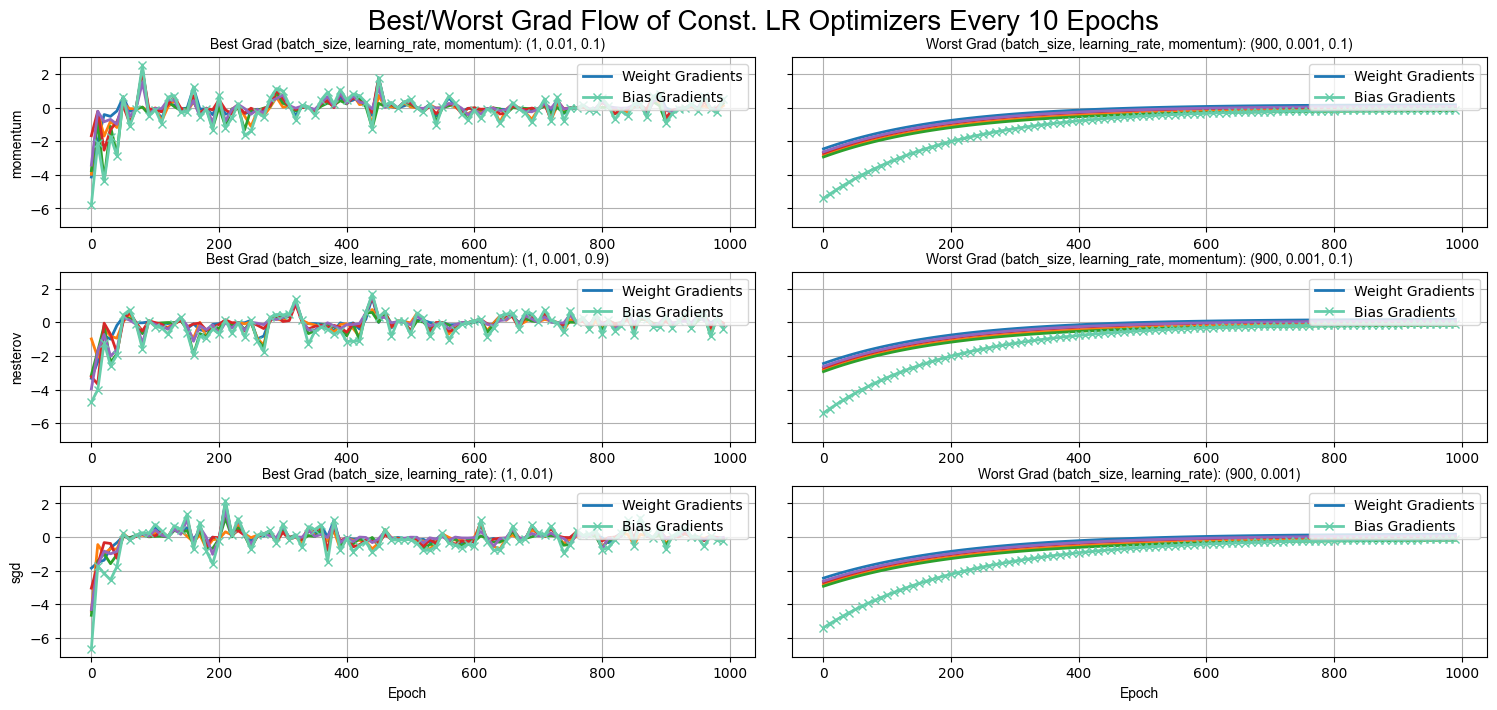

Making figure with 3 rows and 3 columns.


(<Figure size 1500x700 with 9 Axes>,
 array([[<Axes: title={'center': 'Best Param (batch_size, learning_rate, momentum): (1, 0.01, 0.1)'}, ylabel='momentum'>,
         <Axes: title={'center': 'Real Parameters'}>,
         <Axes: title={'center': 'Worst Param (batch_size, learning_rate, momentum) (900, 0.001, 0.1)'}>],
        [<Axes: title={'center': 'Best Param (batch_size, learning_rate, momentum): (1, 0.001, 0.9)'}, ylabel='nesterov'>,
         <Axes: >,
         <Axes: title={'center': 'Worst Param (batch_size, learning_rate, momentum) (900, 0.001, 0.1)'}>],
        [<Axes: title={'center': 'Best Param (batch_size, learning_rate): (1, 0.01)'}, xlabel='Epoch', ylabel='sgd'>,
         <Axes: >,
         <Axes: title={'center': 'Worst Param (batch_size, learning_rate): (900, 0.001)'}, xlabel='Epoch'>]],
       dtype=object))

<Figure size 640x480 with 0 Axes>

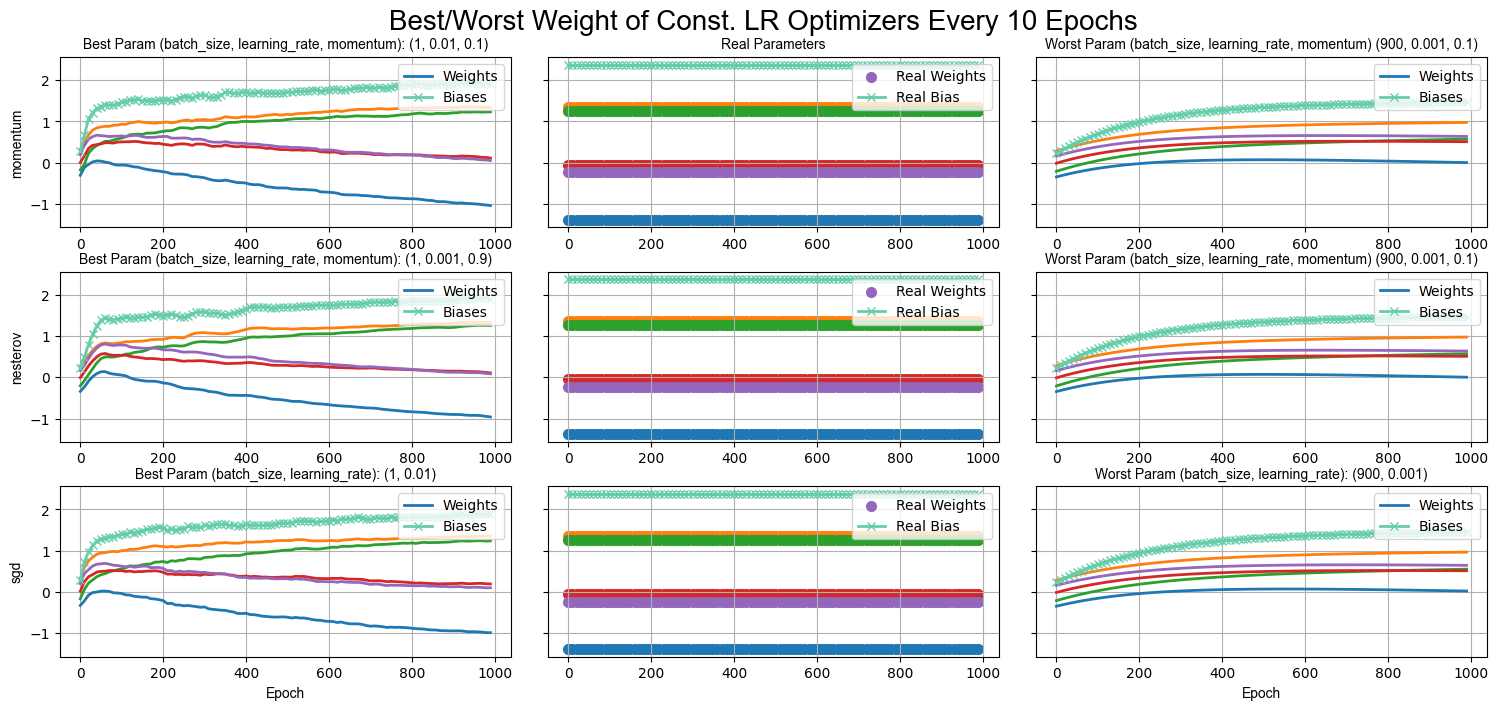

In [17]:
viz = MatplotlibVisualizer(
    config=MatplotlibVizConfig(
        figsize=(15, 7),
        title=f"Best/Worst Grad Flow of Const. LR Optimizers Every {interval} Epochs",
        use_tex=False,
    )
)
viz.clear_plots()
plots, grad_plots = expt_handler.plot_best_and_worst_weight_flow(
    plot_type=PlotType.LINE, selected_loss=selected_loss, filter_optimizers=[Optimizer.ADAM.value, 
                                                                             Optimizer.RMSPROP.value, Optimizer.ADAGRAD.value, Optimizer.ADADELTA.value]
)

for plot in grad_plots:
    plot.X=plot.X[::interval]
    plot.y=plot.y[::interval]
    plot.legend_size=10
    viz.append_plot(plot)
viz.config.title = (
    f"Best/Worst Grad Flow of Const. LR Optimizers Every {interval} Epochs"
)
viz.generate_plots('less_noise_cnst_grad_flow.pdf','pdf')

plt.show()
viz = MatplotlibVisualizer(
    config=MatplotlibVizConfig(
        figsize=(15, 7),
        title=f"Best/Worst Weight of Const. LR Optimizers Every {interval} Epochs",
        use_tex=False,
    )
)
viz.clear_plots()
for plot in plots:
    plot.X=plot.X[::interval]
    plot.y=plot.y[::interval]
    plot.legend_size=10
    viz.append_plot(plot)

viz.generate_plots('less_noise_cnst_weight_flow.pdf','pdf')

In [18]:
plot

Plot(X=array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
       520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640,
       650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770,
       780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900,
       910, 920, 930, 940, 950, 960, 970, 980, 990]), y=[array([0.23250525], dtype=float32), array([0.28519535], dtype=float32), array([0.3355713], dtype=float32), array([0.38373613], dtype=float32), array([0.4297883], dtype=float32), array([0.47382188], dtype=float32), array([0.51592684], dtype=float32), array([0.556189], dtype=float32), array([0.59469056], dtype=float32), array([0.63150996], dtype=float32), array([0.666722], dtype=float32), array([0.70039827], dtype=float32), array(

## Make Table

In [39]:
import pandas as pd

res = {'optimizer':[], 'momentum':[], 'batch_size':[], 'learning_rate':[], 'val_loss':[], 'epoch':[]}
for ename, expt in expt_handler.experiments.items():
    if expt.config.loss.value != LossType.MSE.value:
        continue
    res['optimizer'].append(expt.config.optimizer.value)
    res['momentum'].append(expt.config.momentum)
    res['batch_size'].append(expt.config.batch_size)
    res['learning_rate'].append(expt.config.learning_rate)
    val_loss = np.array([m['val_loss'] for m in expt.losses.values()])
    try:
        res['epoch'].append(np.nanargmin(val_loss))
    except:
        res['epoch'].append(np.nan)
    res['val_loss'].append(np.nanmin(val_loss))
    
df = pd.DataFrame(res)

In [43]:
df.sort_values(by='val_loss', inplace=True)
df.query('optimizer=="adam" and epoch==532')

,optimizer,momentum,batch_size,learning_rate,val_loss,epoch,"val_loss, epoch"
34,adam,0.1,1,0.01,2.219494e-07,532,"0.0, 532"


In [41]:
df['val_loss, epoch'] = df['val_loss'].round(5).astype(str) + ', ' + df['epoch'].astype(str)

In [42]:
# put optimizer in rows

table = df.pivot_table(index=['optimizer', 'momentum'], columns=['batch_size', 'learning_rate'], values='val_loss, epoch', aggfunc='min')
table

batch_size                   1                                         32   \
learning_rate              0.001         0.010         1.000         0.001   
optimizer momentum                                                           
adadelta  0.1       1.13181, 870  0.89498, 998      0.0, 723   5.7938, 996   
adagrad   0.1       0.79589, 865    3e-05, 870      0.0, 856  5.25967, 935   
adam      0.1         2e-05, 801      0.0, 532      0.0, 409  0.33643, 910   
momentum  0.1         3e-05, 440      0.0, 576  177.92186, 0  0.12647, 873   
          0.9           0.0, 188      0.0, 381   26.99226, 2  0.02205, 994   
nesterov  0.1           0.0, 705      0.0, 796  248.97824, 0  0.13219, 901   
          0.9           0.0, 196      0.0, 828  456.06403, 0  0.02017, 887   
rmsprop   0.1           0.0, 925      0.0, 633       0.0, 78  0.23169, 851   
sgd       0.1           0.0, 827      0.0, 353  349.19299, 0  0.16046, 821   

batch_size                                               900                \
learning_rate              0.010         1.000         0.001         0.010   
optimizer momentum                                                           
adadelta  0.1       5.32625, 967  0.01229, 978  7.42895, 999  6.21636, 999   
adagrad   0.1       0.80294, 974  0.00556, 177  6.44447, 999  1.13823, 999   
adam      0.1       0.02439, 990  0.00489, 811  0.51024, 999  0.03353, 999   
momentum  0.1       0.01797, 949   91.20464, 0  0.27394, 999  0.02923, 999   
          0.9       0.00508, 421   88.92398, 0   0.0346, 999  0.01066, 998   
nesterov  0.1       0.01611, 916    97.3871, 0  0.27393, 999  0.02923, 999   
          0.9       0.00576, 628  460.20142, 0  0.03461, 999  0.01066, 999   
rmsprop   0.1       0.00592, 625  0.00756, 147  0.33971, 999  0.01046, 896   
sgd       0.1       0.02218, 958   98.53383, 0  0.28195, 999  0.03475, 999   

batch_size                        
learning_rate              1.000  
optimizer momentum                
adadelta  0.1       0.01049, 882  
adagrad   0.1       0.01066, 736  
adam      0.1        0.01041, 94  
momentum  0.1        96.20892, 0  
          0.9        96.20889, 0  
nesterov  0.1       122.19971, 0  
          0.9       442.23468, 0  
rmsprop   0.1       0.01047, 251  
sgd       0.1        96.20881, 0

In [36]:
table.to_clipboard()